<a href="https://colab.research.google.com/github/freethechicken/pbh_simulations/blob/main/RFSIMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Import packages

import cupy as cp
from cupyx.scipy.special import erf

import numpy as np
import matplotlib.pyplot as plt
import imageio
import gc
import os
import psutil

from scipy.special import erf
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

import h5py

In [2]:
# @title 1.11 GPU Random field simulations

class GPU_RFSIM:

    def __init__(self, mean, std_dev, pixel, z_pixel, amplitude, k_power, lamb, n_sigma):
        self.mean = mean
        self.std_dev = std_dev
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.amplitude = amplitude
        self.k_power = k_power
        self.lamb = lamb
        self.n_sigma = n_sigma

    def get_process_memory(self):
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / (1024 ** 2)  # Return memory usage in MB

    def grf_32f(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel)).astype(cp.float32)
        #print(f"white_noise allocates: {white_noise.nbytes / (1024**2):.2f} MB of memory.")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        fft_white_noise = cp.fft.fftn(white_noise).astype(cp.complex64)
        del white_noise
        gc.collect()
        #print(f"fft_white_noise allocates: {fft_white_noise.nbytes / (1024**2):.2f} MB of memory.")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx.astype(cp.float32), ky.astype(cp.float32), kz.astype(cp.float32), sparse = True)
        del kx, ky, kz
        gc.collect()
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2).astype(cp.float32)
        k_norm[0][0][0] = cp.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid
        gc.collect()
        #print(f"k_norm allocates: {k_norm.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power))).astype(cp.complex64)  # P(k)=amplitude/k^{power},
        del k_norm
        gc.collect()
        #print(f"power_spectrum allocates: {power_spectrum.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise
        gc.collect()
        #print(f"fourier_amplitudes_sqrt allocates: {fourier_amplitudes_sqrt.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()
        #print(f"gaussian_random_field allocates: {gaussian_random_field.nbytes / (1024**2):.2f} MB of memory")
        print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        return gaussian_random_field


    def gaussian_to_exp(self, grf, lam):
        grf_mean = cp.mean(grf)
        grf_std_dev = cp.std(grf)
        xu = 0.5 * (1 + erf((grf - grf_mean) / (cp.sqrt(2) * grf_std_dev)))

        gc.collect()

        exprf = -1/self.lamb  * cp.log(1 - xu)

        return exprf
#        return gaussian_random_field

    def statistic_overview(self, exprf):

        all_points = cp.asnumpy(exprf.flatten())
        exprf_std = np.std(all_points)
        exprf_mean = np.mean(all_points)
        cutoff = exprf_mean + self.n_sigma*exprf_std

        plt.style.use('seaborn-darkgrid')
        #print(f'Standard deviation = {exprf_std_3d:.2f}')
        #print(f'Mean = {exprf_mean_3d:.2f}')
        #print(f'Cutoff = {cutoff_3d:.2f}, i.e. {n_sigma} Sigmas from the mean at {exprf_mean_3d:.2f}')

        # Create a figure object
        fig, ax = plt.subplots()

        ax.hist(all_points, bins=100)
        ax.set_yscale('log')
        ax.set_xlabel('Field amplitude', fontsize=12)
        ax.set_ylabel('Number of data points (Log)', fontsize=12)
        ax.axvline(x=cutoff, color='r', linestyle='-', label='Cutoff amplitude')

        # Add text to the plot
        textstr = f'Std. Dev. = {exprf_std:.2f}\nMean = {exprf_mean:.2f}\nCutoff = {cutoff:.2f} ({n_sigma} Std. Dev. from mean)'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax.set_title('Random Field Statistics', fontsize=14)
        ax.legend(loc='upper right')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Save the plot with text
        #plt.savefig(f'Statistic_info_Threshold_at_{cutoff}.pdf')
        plt.show()

        return fig, cutoff, exprf_std, exprf_mean

In [3]:
# @title 1.12 GPU Cluster analysis

class GPU_CLUS_ANAL:

    def __init__(self, exprf, lx, ly, lz , pixel, z_pixel):
        self.lx = lx
        self.ly = ly
        self.lz = lz
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.exprf = exprf

    def masking(self, cutoff):
        # 5. Save mask and positions where amplitude exceed threshold
        mask = cp.abs(self.exprf) > cutoff
        masked_positions = cp.argwhere(mask)
        # cp.save(f'mask_at_{cutoff:.1f}.npy', mask)
        # cp.save(f'mask_positions_at_{cutoff:.1f}.npy', masked_positions)

        return masked_positions

    def dbscan(self, eps, min_sam, masked_positions):
        dbscans = DBSCAN(eps=eps, min_samples=min_sam)
        cluster_labels = dbscans.fit_predict(masked_positions)

        return cluster_labels

    def submanifolds(self, masked_positions):
        sub_manifolds_list={}
        total_mass={}

        for ii in range(masked_positions.shape[0]):
            x, y, z = masked_positions[ii]
            x_min, x_max = max(x-self.lx,0), min(x+self.lx +1, self.pixel)
            y_min, y_max = max(y-self.ly,0), min(y+self.ly +1, self.pixel)
            z_min, z_max = max(z-self.lz,0), min(z+self.lz +1, self.z_pixel)

            sub_exprf = self.exprf[x_min:x_max, y_min:y_max, z_min:z_max]
            sub_manifolds_list[ii] = sub_exprf
            total_mass[ii] = cp.sum(sub_exprf)

        cp.save(f'sub_manifolds_list.npy', sub_manifolds_list )
        cp.save(f'total_amplitude.npy', total_mass)

        return sub_manifolds_list, total_mass

        # @title 1.4 DBSCAN

    def cluster_distances(self, masked_positions, labels):
        cluster_centers = {}

        # Find unique cluster labels (excluding noise -1)
        unique_labels = set(labels) - {-1}

        # Calculate cluster centers
        for ii in set(unique_labels):
            cluster_indices = cp.where(labels == ii)[0]
            cluster_positions = masked_positions[cluster_indices]
            cluster_center = cp.mean(cluster_positions, axis=0)
            cluster_centers[ii] = cluster_center

        # Calculate distances between cluster centers
        distances = []
        for aa in cluster_centers:
            for bb in cluster_centers:
                if aa != bb & bb > aa:
                    distance = euclidean_distances([cluster_centers[aa]], [cluster_centers[bb]])
                    distances.append((aa,bb, distance))

        return distances


    def cluster_distribution_3d(self, positions, labels):

        all_cluster_position = {}
        cluster_field_values={}
        for ii in set(labels):
            cluster_indices = cp.where(labels == ii)[0]
            all_cluster_position[ii+1] = positions[cluster_indices]
            cluster_field_values[ii+1] = self.exprf[all_cluster_position[ii+1][:,0],
                                            all_cluster_position[ii+1][:,1],
                                            all_cluster_position[ii+1][:,2]]

        for ii in set(labels):
            plt.hist(cluster_field_values[ii+1].flatten(), bins = 100, label=f'Cluster {ii}', alpha=0.3);
            #plt.yscale('log')
            plt.xlabel('Field amplitude')
            plt.ylabel('Number of samples')
            plt.title(f'Cluster Distribution')
            plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
            plt.grid(True)

        return cluster_field_values


    def cluster_plot_3D(self, positions, labels):

        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')

        for ii in set(labels):
            cluster_index = cp.where(labels == ii)[0]
            cluster_positions = positions[cluster_index]

            if ii == -1:
                ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                        s=3, color='black', label='Anomaly')
            else:
                ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                        s=3, label=f'Cluster {ii}')

        ax.set_xlabel('X', fontsize=10)
        ax.set_ylabel('Y', fontsize=10)
        ax.set_zlabel('Z', fontsize=10)
        ax.set_title(f'Clustered 3D field config', fontsize=14)
        plt.legend()
        plt.show()

In [4]:
# @title 1.21 CPU Random field simulations

class RFSIM:

    def __init__(self, mean, std_dev, pixel, z_pixel, amplitude, k_power, lamb, n_sigma):
        self.mean = mean
        self.std_dev = std_dev
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.amplitude = amplitude
        self.k_power = k_power
        self.lamb = lamb
        self.n_sigma = n_sigma

    def get_process_memory(self):
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / (1024 ** 2)  # Return memory usage in MB

    def grf_32f(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = np.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel)).astype(np.float32)
        print(f"white_noise allocates: {white_noise.nbytes / (1024**2):.2f} MB of memory.")
        print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        fft_white_noise = np.fft.fftn(white_noise).astype(np.complex64)
        del white_noise
        gc.collect()
        print(f"fft_white_noise allocates: {fft_white_noise.nbytes / (1024**2):.2f} MB of memory.")
        print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Generating FFT momentum
        kx = np.fft.fftfreq(self.pixel)*self.pixel
        ky = np.fft.fftfreq(self.pixel)*self.pixel
        kz = np.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = np.meshgrid(kx.astype(np.float32), ky.astype(np.float32), kz.astype(np.float32), sparse = True)
        del kx, ky, kz
        gc.collect()
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = np.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2).astype(np.float32)
        k_norm[0][0][0] = np.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid
        gc.collect()
        print(f"k_norm allocates: {k_norm.nbytes / (1024**2):.2f} MB of memory")
        print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*np.pi/self.pixel)*k_norm)**(-1*self.k_power))).astype(np.complex64)  # P(k)=amplitude/k^{power},
        del k_norm
        gc.collect()
        print(f"power_spectrum allocates: {power_spectrum.nbytes / (1024**2):.2f} MB of memory")
        print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  np.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise
        gc.collect()
        print(f"fourier_amplitudes_sqrt allocates: {fourier_amplitudes_sqrt.nbytes / (1024**2):.2f} MB of memory")
        print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = np.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()
        print(f"gaussian_random_field allocates: {gaussian_random_field.nbytes / (1024**2):.2f} MB of memory")
        print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        return gaussian_random_field


    def gaussian_to_exp(self, grf, lam):
        grf_mean = np.mean(grf)
        grf_std_dev = np.std(grf)
        xu = 0.5 * (1 + erf((grf - grf_mean) / (np.sqrt(2) * grf_std_dev)))

        gc.collect()

        exprf = -1/self.lamb  * np.log(1 - xu)

        return exprf
#        return gaussian_random_field

    def statistic_overview(self, exprf):

        all_points = exprf.flatten()
        exprf_std = np.std(all_points)
        exprf_mean = np.mean(all_points)
        cutoff = exprf_mean + self.n_sigma*exprf_std

        plt.style.use('seaborn-darkgrid')
        #print(f'Standard deviation = {exprf_std_3d:.2f}')
        #print(f'Mean = {exprf_mean_3d:.2f}')
        #print(f'Cutoff = {cutoff_3d:.2f}, i.e. {n_sigma} Sigmas from the mean at {exprf_mean_3d:.2f}')

        # Create a figure object
        fig, ax = plt.subplots()

        ax.hist(all_points, bins=100)
        ax.set_yscale('log')
        ax.set_xlabel('Field amplitude', fontsize=12)
        ax.set_ylabel('Number of data points (Log)', fontsize=12)
        ax.axvline(x=cutoff, color='r', linestyle='-', label='Cutoff amplitude')

        # Add text to the plot
        textstr = f'Std. Dev. = {exprf_std:.2f}\nMean = {exprf_mean:.2f}\nCutoff = {cutoff:.2f} ({n_sigma} Std. Dev. from mean)'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax.set_title('Random Field Statistics', fontsize=14)
        ax.legend(loc='upper right')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Save the plot with text
        #plt.savefig(f'Statistic_info_Threshold_at_{cutoff}.pdf')
        plt.show()

        return fig, cutoff, exprf_std, exprf_mean

In [5]:
# @title 1.22 Cluster analysis

class CLUS_ANAL:

    def __init__(self, exprf, lx, ly, lz , pixel, z_pixel):
        self.lx = lx
        self.ly = ly
        self.lz = lz
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.exprf = exprf

    def masking(self, cutoff):
        # 5. Save mask and positions where amplitude exceed threshold
        mask = np.abs(self.exprf) > cutoff
        masked_positions = np.argwhere(mask)
        # np.save(f'mask_at_{cutoff:.1f}.npy', mask)
        # np.save(f'mask_positions_at_{cutoff:.1f}.npy', masked_positions)

        return masked_positions

    def dbscan(self, eps, min_sam, masked_positions):
        dbscans = DBSCAN(eps=eps, min_samples=min_sam)
        cluster_labels = dbscans.fit_predict(masked_positions)

        return cluster_labels

    def submanifolds(self, masked_positions):
        sub_manifolds_list={}
        total_mass={}

        for ii in range(masked_positions.shape[0]):
            x, y, z = masked_positions[ii]
            x_min, x_max = max(x-self.lx,0), min(x+self.lx +1, self.pixel)
            y_min, y_max = max(y-self.ly,0), min(y+self.ly +1, self.pixel)
            z_min, z_max = max(z-self.lz,0), min(z+self.lz +1, self.z_pixel)

            sub_exprf = self.exprf[x_min:x_max, y_min:y_max, z_min:z_max]
            sub_manifolds_list[ii] = sub_exprf
            total_mass[ii] = np.sum(sub_exprf)

        np.save(f'sub_manifolds_list.npy', sub_manifolds_list )
        np.save(f'total_amplitude.npy', total_mass)

        return sub_manifolds_list, total_mass

        # @title 1.4 DBSCAN

    def cluster_distances(self, masked_positions, labels):
        cluster_centers = {}

        # Find unique cluster labels (excluding noise -1)
        unique_labels = set(labels) - {-1}

        # Calculate cluster centers
        for ii in set(unique_labels):
            cluster_indices = np.where(labels == ii)[0]
            cluster_positions = masked_positions[cluster_indices]
            cluster_center = np.mean(cluster_positions, axis=0)
            cluster_centers[ii] = cluster_center

        # Calculate distances between cluster centers
        distances = []
        for aa in cluster_centers:
            for bb in cluster_centers:
                if aa != bb & bb > aa:
                    distance = euclidean_distances([cluster_centers[aa]], [cluster_centers[bb]])
                    distances.append((aa,bb, distance))

        return distances


    def cluster_distribution_3d(self, positions, labels):

        all_cluster_position = {}
        cluster_field_values={}
        for ii in set(labels):
            cluster_indices = np.where(labels == ii)[0]
            all_cluster_position[ii+1] = positions[cluster_indices]
            cluster_field_values[ii+1] = self.exprf[all_cluster_position[ii+1][:,0],
                                            all_cluster_position[ii+1][:,1],
                                            all_cluster_position[ii+1][:,2]]

        for ii in set(labels):
            plt.hist(cluster_field_values[ii+1].flatten(), bins = 100, label=f'Cluster {ii}', alpha=0.3);
            #plt.yscale('log')
            plt.xlabel('Field amplitude')
            plt.ylabel('Number of samples')
            plt.title(f'Cluster Distribution')
            plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
            plt.grid(True)

        return cluster_field_values


    def cluster_plot_3D(self, positions, labels):

        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')

        for ii in set(labels):
            cluster_index = np.where(labels == ii)[0]
            cluster_positions = positions[cluster_index]

            if ii == -1:
                ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                        s=3, color='black', label='Anomaly')
            else:
                ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                        s=3, label=f'Cluster {ii}')

        ax.set_xlabel('X', fontsize=10)
        ax.set_ylabel('Y', fontsize=10)
        ax.set_zlabel('Z', fontsize=10)
        ax.set_title(f'Clustered 3D field config', fontsize=14)
        plt.legend()
        plt.show()

In [6]:
# @title  1.5 Visualization

def plot_3d_scatter_field(exprf, cutoff):
    # Normalize the field values
    normalized_fig = exprf / np.abs(exprf).max()

    # Create 3D meshgrid
    x, y, z = np.meshgrid(range(exprf.shape[0]),
                          range(exprf.shape[1]),
                          range(exprf.shape[2]))

    figu = plt.figure(figsize=(6, 6))
    ax = figu.add_subplot(111, projection='3d')

    # Plot scatters above the threshold values
    scatterplts = ax.scatter(x[np.abs(exprf) > cutoff],
                            y[np.abs(exprf)  > cutoff],
                            z[np.abs(exprf)  > cutoff],
                            c=normalized_fig[np.abs(exprf) > cutoff],
                            s=5,
                            cmap='viridis')
    #                        alpha=alphas[np.abs(normalized_fig) > threshold])

    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    ax.set_title(f'3D Field Config', fontsize=14)
    figu.colorbar(scatterplts, ax=ax, label='Field Amplitude', shrink=0.5)
    figu.patch.set_facecolor('white')

    plt.show()



In [9]:
# Paramters
pixel = 2**9
z_pixel = pixel
n_sigma = 25
l = 6
lx = l
ly = l
lz = l

Nloops = 2000

Processing:   0%|          | 0/2000 [00:00<?, ?it/s]

Total memory usage: 485.59 MB


Processing:   0%|          | 1/2000 [00:01<40:01,  1.20s/it]

Total memory usage: 485.59 MB


Processing:   0%|          | 2/2000 [00:01<31:09,  1.07it/s]

Total memory usage: 485.59 MB


Processing:   0%|          | 3/2000 [00:02<29:46,  1.12it/s]

Total memory usage: 485.59 MB


Processing:   0%|          | 4/2000 [00:03<29:09,  1.14it/s]

Total memory usage: 485.59 MB


Processing:   0%|          | 5/2000 [00:04<28:29,  1.17it/s]

Total memory usage: 485.59 MB


Processing:   0%|          | 6/2000 [00:05<28:07,  1.18it/s]

Total memory usage: 485.59 MB


Processing:   0%|          | 7/2000 [00:06<27:03,  1.23it/s]

Total memory usage: 485.59 MB


Processing:   0%|          | 8/2000 [00:06<26:25,  1.26it/s]

Total memory usage: 485.59 MB


Processing:   0%|          | 9/2000 [00:07<25:57,  1.28it/s]

Total memory usage: 485.59 MB


Processing:   0%|          | 10/2000 [00:08<25:30,  1.30it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 11/2000 [00:09<25:23,  1.31it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 12/2000 [00:09<25:12,  1.31it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 13/2000 [00:10<25:13,  1.31it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 14/2000 [00:11<25:04,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 15/2000 [00:12<25:01,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 16/2000 [00:12<25:00,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 17/2000 [00:13<24:56,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 18/2000 [00:14<24:53,  1.33it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 19/2000 [00:15<25:17,  1.31it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 20/2000 [00:15<25:55,  1.27it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 21/2000 [00:16<26:11,  1.26it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 22/2000 [00:17<26:24,  1.25it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 23/2000 [00:18<26:44,  1.23it/s]

Total memory usage: 485.59 MB


Processing:   1%|          | 24/2000 [00:19<27:04,  1.22it/s]

Total memory usage: 485.59 MB


Processing:   1%|▏         | 25/2000 [00:20<26:21,  1.25it/s]

Total memory usage: 485.59 MB


Processing:   1%|▏         | 26/2000 [00:20<25:48,  1.27it/s]

Total memory usage: 485.59 MB


Processing:   1%|▏         | 27/2000 [00:21<25:23,  1.29it/s]

Total memory usage: 485.59 MB


Processing:   1%|▏         | 28/2000 [00:22<25:11,  1.30it/s]

Total memory usage: 485.59 MB


Processing:   1%|▏         | 29/2000 [00:22<24:56,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 30/2000 [00:23<24:49,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 31/2000 [00:24<24:49,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 32/2000 [00:25<24:46,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 33/2000 [00:26<24:43,  1.33it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 34/2000 [00:26<24:39,  1.33it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 35/2000 [00:27<24:40,  1.33it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 36/2000 [00:28<24:40,  1.33it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 37/2000 [00:29<24:48,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 38/2000 [00:29<25:29,  1.28it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 39/2000 [00:30<25:54,  1.26it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 40/2000 [00:31<26:10,  1.25it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 41/2000 [00:32<26:35,  1.23it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 42/2000 [00:33<25:59,  1.26it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 43/2000 [00:33<25:28,  1.28it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 44/2000 [00:34<25:08,  1.30it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 45/2000 [00:35<24:49,  1.31it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 46/2000 [00:36<25:05,  1.30it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 47/2000 [00:36<24:48,  1.31it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 48/2000 [00:37<24:43,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   2%|▏         | 49/2000 [00:38<24:41,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   2%|▎         | 50/2000 [00:39<24:49,  1.31it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 51/2000 [00:39<24:42,  1.31it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 52/2000 [00:40<24:43,  1.31it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 53/2000 [00:41<24:26,  1.33it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 54/2000 [00:42<24:24,  1.33it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 55/2000 [00:43<25:11,  1.29it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 56/2000 [00:43<25:36,  1.26it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 57/2000 [00:44<26:08,  1.24it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 58/2000 [00:45<26:15,  1.23it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 59/2000 [00:46<26:19,  1.23it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 60/2000 [00:47<25:37,  1.26it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 61/2000 [00:47<25:09,  1.28it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 62/2000 [00:48<24:48,  1.30it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 63/2000 [00:49<24:31,  1.32it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 64/2000 [00:50<24:20,  1.33it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 65/2000 [00:50<24:12,  1.33it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 66/2000 [00:51<24:10,  1.33it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 67/2000 [00:52<24:03,  1.34it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 68/2000 [00:52<24:01,  1.34it/s]

Total memory usage: 485.59 MB


Processing:   3%|▎         | 69/2000 [00:53<24:04,  1.34it/s]

Total memory usage: 485.59 MB


Processing:   4%|▎         | 70/2000 [00:54<24:00,  1.34it/s]

Total memory usage: 485.59 MB


Processing:   4%|▎         | 71/2000 [00:55<23:58,  1.34it/s]

Total memory usage: 485.59 MB


Processing:   4%|▎         | 72/2000 [00:55<24:01,  1.34it/s]

Total memory usage: 485.59 MB


Processing:   4%|▎         | 73/2000 [00:56<24:44,  1.30it/s]

Total memory usage: 485.59 MB


Processing:   4%|▎         | 74/2000 [00:57<25:27,  1.26it/s]

Total memory usage: 485.59 MB


Processing:   4%|▍         | 75/2000 [00:58<25:39,  1.25it/s]

Total memory usage: 485.59 MB


<ipython-input-2-0e79851809b3>:92: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


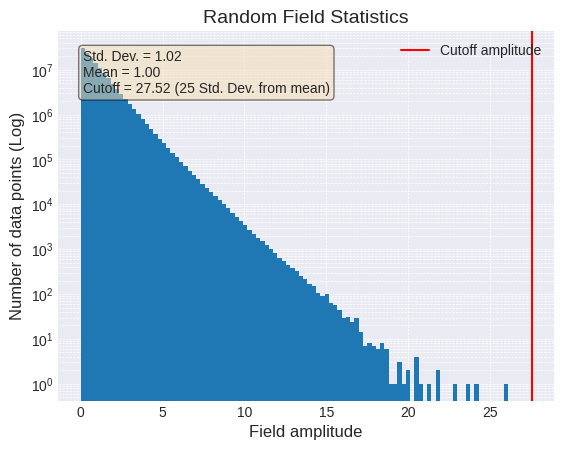

Processing:   4%|▍         | 76/2000 [01:12<2:36:27,  4.88s/it]

Found rare event at simulation 75
Total memory usage: 521.64 MB


Processing:   4%|▍         | 77/2000 [01:13<1:57:28,  3.67s/it]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 78/2000 [01:14<1:29:55,  2.81s/it]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 79/2000 [01:15<1:10:26,  2.20s/it]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 80/2000 [01:16<56:57,  1.78s/it]  

Total memory usage: 521.64 MB


Processing:   4%|▍         | 81/2000 [01:16<47:26,  1.48s/it]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 82/2000 [01:17<41:04,  1.28s/it]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 83/2000 [01:18<36:21,  1.14s/it]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 84/2000 [01:19<33:00,  1.03s/it]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 85/2000 [01:20<30:43,  1.04it/s]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 86/2000 [01:20<29:10,  1.09it/s]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 87/2000 [01:21<28:15,  1.13it/s]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 88/2000 [01:22<27:34,  1.16it/s]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 89/2000 [01:23<27:43,  1.15it/s]

Total memory usage: 521.64 MB


Processing:   4%|▍         | 90/2000 [01:24<27:59,  1.14it/s]

Total memory usage: 521.64 MB


Processing:   5%|▍         | 91/2000 [01:25<28:06,  1.13it/s]

Total memory usage: 521.64 MB


Processing:   5%|▍         | 92/2000 [01:26<28:30,  1.12it/s]

Total memory usage: 521.64 MB


Processing:   5%|▍         | 93/2000 [01:26<27:38,  1.15it/s]

Total memory usage: 521.64 MB


Processing:   5%|▍         | 94/2000 [01:27<26:59,  1.18it/s]

Total memory usage: 521.64 MB


Processing:   5%|▍         | 95/2000 [01:28<26:30,  1.20it/s]

Total memory usage: 521.64 MB


Processing:   5%|▍         | 96/2000 [01:29<26:12,  1.21it/s]

Total memory usage: 521.64 MB


Processing:   5%|▍         | 97/2000 [01:30<25:55,  1.22it/s]

Total memory usage: 521.64 MB


Processing:   5%|▍         | 98/2000 [01:30<25:50,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   5%|▍         | 99/2000 [01:31<25:46,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   5%|▌         | 100/2000 [01:32<25:47,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   5%|▌         | 101/2000 [01:33<25:34,  1.24it/s]

Total memory usage: 521.64 MB


Processing:   5%|▌         | 102/2000 [01:34<25:27,  1.24it/s]

Total memory usage: 521.64 MB


Processing:   5%|▌         | 103/2000 [01:34<25:30,  1.24it/s]

Total memory usage: 521.64 MB


Processing:   5%|▌         | 104/2000 [01:35<25:28,  1.24it/s]

Total memory usage: 521.64 MB


Processing:   5%|▌         | 105/2000 [01:36<26:42,  1.18it/s]

Total memory usage: 521.64 MB


Processing:   5%|▌         | 106/2000 [01:37<27:18,  1.16it/s]

Total memory usage: 521.64 MB


Processing:   5%|▌         | 107/2000 [01:38<27:52,  1.13it/s]

Total memory usage: 521.64 MB


Processing:   5%|▌         | 108/2000 [01:39<28:09,  1.12it/s]

Total memory usage: 521.64 MB


Processing:   5%|▌         | 109/2000 [01:40<27:23,  1.15it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 110/2000 [01:41<26:51,  1.17it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 111/2000 [01:41<26:29,  1.19it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 112/2000 [01:42<26:06,  1.21it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 113/2000 [01:43<25:50,  1.22it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 114/2000 [01:44<25:42,  1.22it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 115/2000 [01:45<25:45,  1.22it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 116/2000 [01:45<25:36,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 117/2000 [01:46<25:30,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 118/2000 [01:47<25:25,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 119/2000 [01:48<25:25,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 120/2000 [01:49<25:27,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 121/2000 [01:50<26:13,  1.19it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 122/2000 [01:51<26:58,  1.16it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 123/2000 [01:51<27:25,  1.14it/s]

Total memory usage: 521.64 MB


Processing:   6%|▌         | 124/2000 [01:52<27:40,  1.13it/s]

Total memory usage: 521.64 MB


Processing:   6%|▋         | 125/2000 [01:53<26:58,  1.16it/s]

Total memory usage: 521.64 MB


Processing:   6%|▋         | 126/2000 [01:54<26:34,  1.18it/s]

Total memory usage: 521.64 MB


Processing:   6%|▋         | 127/2000 [01:55<26:17,  1.19it/s]

Total memory usage: 521.64 MB


Processing:   6%|▋         | 128/2000 [01:56<25:55,  1.20it/s]

Total memory usage: 521.64 MB


Processing:   6%|▋         | 129/2000 [01:56<25:40,  1.21it/s]

Total memory usage: 521.64 MB


Processing:   6%|▋         | 130/2000 [01:57<25:36,  1.22it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 131/2000 [01:58<25:29,  1.22it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 132/2000 [01:59<25:18,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 133/2000 [02:00<25:23,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 134/2000 [02:00<25:16,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 135/2000 [02:01<25:07,  1.24it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 136/2000 [02:02<25:16,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 137/2000 [02:03<26:31,  1.17it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 138/2000 [02:04<26:55,  1.15it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 139/2000 [02:05<27:31,  1.13it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 140/2000 [02:06<27:52,  1.11it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 141/2000 [02:07<27:00,  1.15it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 142/2000 [02:07<26:22,  1.17it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 143/2000 [02:08<26:06,  1.19it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 144/2000 [02:09<25:52,  1.20it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 145/2000 [02:10<25:27,  1.21it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 146/2000 [02:11<25:22,  1.22it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 147/2000 [02:11<25:14,  1.22it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 148/2000 [02:12<25:23,  1.22it/s]

Total memory usage: 521.64 MB


Processing:   7%|▋         | 149/2000 [02:13<25:17,  1.22it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 150/2000 [02:14<25:01,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 151/2000 [02:15<24:58,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 152/2000 [02:16<24:56,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 153/2000 [02:16<25:56,  1.19it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 154/2000 [02:17<26:26,  1.16it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 155/2000 [02:18<26:44,  1.15it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 156/2000 [02:19<27:19,  1.12it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 157/2000 [02:20<26:34,  1.16it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 158/2000 [02:21<26:05,  1.18it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 159/2000 [02:22<25:40,  1.19it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 160/2000 [02:22<25:18,  1.21it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 161/2000 [02:23<25:15,  1.21it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 162/2000 [02:24<24:56,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 163/2000 [02:25<24:51,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 164/2000 [02:26<24:43,  1.24it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 165/2000 [02:26<24:40,  1.24it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 166/2000 [02:27<24:35,  1.24it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 167/2000 [02:28<24:28,  1.25it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 168/2000 [02:29<24:36,  1.24it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 169/2000 [02:30<25:32,  1.19it/s]

Total memory usage: 521.64 MB


Processing:   8%|▊         | 170/2000 [02:31<26:00,  1.17it/s]

Total memory usage: 521.64 MB


Processing:   9%|▊         | 171/2000 [02:32<26:28,  1.15it/s]

Total memory usage: 521.64 MB


Processing:   9%|▊         | 172/2000 [02:33<27:24,  1.11it/s]

Total memory usage: 521.64 MB


Processing:   9%|▊         | 173/2000 [02:33<26:48,  1.14it/s]

Total memory usage: 521.64 MB


Processing:   9%|▊         | 174/2000 [02:34<26:09,  1.16it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 175/2000 [02:35<25:48,  1.18it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 176/2000 [02:36<25:25,  1.20it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 177/2000 [02:37<25:10,  1.21it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 178/2000 [02:37<25:01,  1.21it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 179/2000 [02:38<24:50,  1.22it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 180/2000 [02:39<24:43,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 181/2000 [02:40<24:30,  1.24it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 182/2000 [02:41<24:38,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 183/2000 [02:41<24:31,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 184/2000 [02:42<24:30,  1.24it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 185/2000 [02:43<24:31,  1.23it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 186/2000 [02:44<25:11,  1.20it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 187/2000 [02:45<25:44,  1.17it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 188/2000 [02:46<26:00,  1.16it/s]

Total memory usage: 521.64 MB


Processing:   9%|▉         | 189/2000 [02:47<26:11,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  10%|▉         | 190/2000 [02:47<25:38,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  10%|▉         | 191/2000 [02:48<25:12,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  10%|▉         | 192/2000 [02:49<24:57,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  10%|▉         | 193/2000 [02:50<24:45,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  10%|▉         | 194/2000 [02:51<24:35,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  10%|▉         | 195/2000 [02:51<24:30,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  10%|▉         | 196/2000 [02:52<24:22,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  10%|▉         | 197/2000 [02:53<24:16,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  10%|▉         | 198/2000 [02:54<24:14,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  10%|▉         | 199/2000 [02:55<24:10,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  10%|█         | 200/2000 [02:55<24:11,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  10%|█         | 201/2000 [02:56<24:12,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  10%|█         | 202/2000 [02:57<25:03,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  10%|█         | 203/2000 [02:58<25:32,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  10%|█         | 204/2000 [02:59<25:57,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  10%|█         | 205/2000 [03:00<26:38,  1.12it/s]

Total memory usage: 521.64 MB


Processing:  10%|█         | 206/2000 [03:01<25:55,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  10%|█         | 207/2000 [03:02<25:23,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  10%|█         | 208/2000 [03:02<25:08,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  10%|█         | 209/2000 [03:03<24:54,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  10%|█         | 210/2000 [03:04<24:37,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 211/2000 [03:05<24:40,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 212/2000 [03:06<24:20,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 213/2000 [03:06<24:20,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 214/2000 [03:07<24:10,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 215/2000 [03:08<24:06,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 216/2000 [03:09<24:14,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 217/2000 [03:10<24:24,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 218/2000 [03:11<25:01,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 219/2000 [03:12<25:43,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 220/2000 [03:12<25:55,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 221/2000 [03:13<26:20,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 222/2000 [03:14<25:35,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 223/2000 [03:15<25:18,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  11%|█         | 224/2000 [03:16<24:47,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  11%|█▏        | 225/2000 [03:17<24:50,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  11%|█▏        | 226/2000 [03:17<24:33,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  11%|█▏        | 227/2000 [03:18<24:20,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  11%|█▏        | 228/2000 [03:19<24:11,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  11%|█▏        | 229/2000 [03:20<24:05,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 230/2000 [03:21<24:09,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 231/2000 [03:21<23:59,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 232/2000 [03:22<23:57,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 233/2000 [03:23<23:55,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 234/2000 [03:24<24:44,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 235/2000 [03:25<25:08,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 236/2000 [03:26<25:30,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 237/2000 [03:27<26:00,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 238/2000 [03:28<25:16,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 239/2000 [03:28<24:46,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 240/2000 [03:29<24:25,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 241/2000 [03:30<24:06,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 242/2000 [03:31<24:02,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 243/2000 [03:32<24:01,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 244/2000 [03:32<24:09,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 245/2000 [03:33<24:09,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 246/2000 [03:34<23:56,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 247/2000 [03:35<23:58,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 248/2000 [03:36<23:48,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▏        | 249/2000 [03:36<23:49,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  12%|█▎        | 250/2000 [03:37<24:41,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 251/2000 [03:38<25:07,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 252/2000 [03:39<25:21,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 253/2000 [03:40<25:54,  1.12it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 254/2000 [03:41<25:09,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 255/2000 [03:42<24:38,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 256/2000 [03:43<24:16,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 257/2000 [03:43<23:54,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 258/2000 [03:44<23:45,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 259/2000 [03:45<23:33,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 260/2000 [03:46<23:27,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 261/2000 [03:47<23:54,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 262/2000 [03:47<23:43,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 263/2000 [03:48<23:36,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 264/2000 [03:49<23:40,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 265/2000 [03:50<23:35,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 266/2000 [03:51<24:30,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 267/2000 [03:52<24:50,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 268/2000 [03:53<25:09,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  13%|█▎        | 269/2000 [03:53<25:29,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▎        | 270/2000 [03:54<24:44,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▎        | 271/2000 [03:55<24:13,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▎        | 272/2000 [03:56<23:51,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▎        | 273/2000 [03:57<23:44,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▎        | 274/2000 [03:58<23:46,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 275/2000 [03:58<23:30,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 276/2000 [03:59<23:32,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 277/2000 [04:00<23:28,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 278/2000 [04:01<23:22,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 279/2000 [04:02<23:15,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 280/2000 [04:02<23:12,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 281/2000 [04:03<23:15,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 282/2000 [04:04<24:06,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 283/2000 [04:05<24:43,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 284/2000 [04:06<24:58,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 285/2000 [04:07<25:19,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 286/2000 [04:08<24:51,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 287/2000 [04:08<24:19,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 288/2000 [04:09<23:53,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 289/2000 [04:10<23:28,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  14%|█▍        | 290/2000 [04:11<23:18,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▍        | 291/2000 [04:12<23:10,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▍        | 292/2000 [04:12<23:03,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▍        | 293/2000 [04:13<22:58,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▍        | 294/2000 [04:14<23:09,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▍        | 295/2000 [04:15<23:05,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▍        | 296/2000 [04:16<23:01,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▍        | 297/2000 [04:17<23:04,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▍        | 298/2000 [04:17<23:16,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▍        | 299/2000 [04:18<24:12,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▌        | 300/2000 [04:19<24:40,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▌        | 301/2000 [04:20<24:56,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▌        | 302/2000 [04:21<24:44,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▌        | 303/2000 [04:22<24:07,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▌        | 304/2000 [04:23<23:41,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▌        | 305/2000 [04:23<23:15,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▌        | 306/2000 [04:24<23:01,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▌        | 307/2000 [04:25<22:47,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▌        | 308/2000 [04:26<22:46,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  15%|█▌        | 309/2000 [04:27<22:45,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 310/2000 [04:27<22:34,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 311/2000 [04:28<22:35,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 312/2000 [04:29<22:52,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 313/2000 [04:30<23:01,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 314/2000 [04:31<22:53,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 315/2000 [04:32<23:44,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 316/2000 [04:32<24:21,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 317/2000 [04:33<24:34,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 318/2000 [04:34<24:58,  1.12it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 319/2000 [04:35<24:16,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 320/2000 [04:36<23:46,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 321/2000 [04:37<23:16,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 322/2000 [04:38<23:01,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 323/2000 [04:38<22:54,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▌        | 324/2000 [04:39<22:56,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▋        | 325/2000 [04:40<22:46,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▋        | 326/2000 [04:41<22:45,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▋        | 327/2000 [04:42<22:46,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▋        | 328/2000 [04:42<22:45,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▋        | 329/2000 [04:43<22:36,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  16%|█▋        | 330/2000 [04:44<22:41,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 331/2000 [04:45<23:30,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 332/2000 [04:46<23:51,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 333/2000 [04:47<24:22,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 334/2000 [04:48<24:39,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 335/2000 [04:48<23:57,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 336/2000 [04:49<23:25,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 337/2000 [04:50<23:06,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 338/2000 [04:51<22:47,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 339/2000 [04:52<22:32,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 340/2000 [04:52<22:29,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 341/2000 [04:53<22:20,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 342/2000 [04:54<22:15,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 343/2000 [04:55<22:10,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 344/2000 [04:56<22:05,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 345/2000 [04:56<22:09,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 346/2000 [04:57<22:15,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 347/2000 [04:58<23:16,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 348/2000 [04:59<23:49,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  17%|█▋        | 349/2000 [05:00<24:04,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 350/2000 [05:01<24:42,  1.11it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 351/2000 [05:02<23:55,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 352/2000 [05:03<23:25,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 353/2000 [05:03<22:59,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 354/2000 [05:04<22:45,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 355/2000 [05:05<22:35,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 356/2000 [05:06<22:27,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 357/2000 [05:07<22:23,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 358/2000 [05:07<22:11,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 359/2000 [05:08<22:05,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 360/2000 [05:09<21:56,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 361/2000 [05:10<21:56,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 362/2000 [05:11<22:06,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 363/2000 [05:12<23:13,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 364/2000 [05:13<23:34,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 365/2000 [05:13<23:53,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 366/2000 [05:14<24:18,  1.12it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 367/2000 [05:15<23:51,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 368/2000 [05:16<23:16,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 369/2000 [05:17<22:47,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  18%|█▊        | 370/2000 [05:18<22:31,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▊        | 371/2000 [05:18<22:14,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▊        | 372/2000 [05:19<22:17,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▊        | 373/2000 [05:20<22:04,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▊        | 374/2000 [05:21<21:47,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 375/2000 [05:22<21:40,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 376/2000 [05:22<21:37,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 377/2000 [05:23<21:46,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 378/2000 [05:24<21:44,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 379/2000 [05:25<21:57,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 380/2000 [05:26<22:45,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 381/2000 [05:27<23:08,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 382/2000 [05:28<23:37,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 383/2000 [05:28<23:25,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 384/2000 [05:29<23:01,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 385/2000 [05:30<22:43,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 386/2000 [05:31<22:24,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 387/2000 [05:32<22:11,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 388/2000 [05:32<22:03,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  19%|█▉        | 389/2000 [05:33<21:56,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  20%|█▉        | 390/2000 [05:34<21:55,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  20%|█▉        | 391/2000 [05:35<21:44,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  20%|█▉        | 392/2000 [05:36<22:05,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  20%|█▉        | 393/2000 [05:37<21:59,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  20%|█▉        | 394/2000 [05:37<21:50,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  20%|█▉        | 395/2000 [05:38<21:47,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  20%|█▉        | 396/2000 [05:39<22:29,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  20%|█▉        | 397/2000 [05:40<23:08,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  20%|█▉        | 398/2000 [05:41<23:46,  1.12it/s]

Total memory usage: 521.64 MB


Processing:  20%|█▉        | 399/2000 [05:42<23:51,  1.12it/s]

Total memory usage: 521.64 MB


Processing:  20%|██        | 400/2000 [05:43<23:07,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  20%|██        | 401/2000 [05:43<22:35,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  20%|██        | 402/2000 [05:44<22:20,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  20%|██        | 403/2000 [05:45<22:04,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  20%|██        | 404/2000 [05:46<22:03,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  20%|██        | 405/2000 [05:47<21:46,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  20%|██        | 406/2000 [05:48<21:35,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  20%|██        | 407/2000 [05:48<21:29,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  20%|██        | 408/2000 [05:49<21:29,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  20%|██        | 409/2000 [05:50<21:28,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  20%|██        | 410/2000 [05:51<21:18,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 411/2000 [05:52<21:16,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 412/2000 [05:52<22:04,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 413/2000 [05:53<22:25,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 414/2000 [05:54<22:50,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 415/2000 [05:55<23:17,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 416/2000 [05:56<22:46,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 417/2000 [05:57<22:17,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 418/2000 [05:58<22:01,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 419/2000 [05:58<21:57,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 420/2000 [05:59<21:47,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 421/2000 [06:00<21:32,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 422/2000 [06:01<21:21,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 423/2000 [06:02<21:14,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  21%|██        | 424/2000 [06:02<21:12,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  21%|██▏       | 425/2000 [06:03<21:12,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  21%|██▏       | 426/2000 [06:04<21:12,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  21%|██▏       | 427/2000 [06:05<21:05,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  21%|██▏       | 428/2000 [06:06<21:53,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  21%|██▏       | 429/2000 [06:07<22:27,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 430/2000 [06:08<22:45,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 431/2000 [06:08<23:04,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 432/2000 [06:09<22:23,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 433/2000 [06:10<22:00,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 434/2000 [06:11<21:38,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 435/2000 [06:12<21:27,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 436/2000 [06:12<21:26,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 437/2000 [06:13<21:10,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 438/2000 [06:14<21:08,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 439/2000 [06:15<21:02,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 440/2000 [06:16<21:01,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 441/2000 [06:17<21:04,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 442/2000 [06:17<20:58,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 443/2000 [06:18<20:59,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 444/2000 [06:19<21:49,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 445/2000 [06:20<22:20,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 446/2000 [06:21<22:38,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 447/2000 [06:22<22:57,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 448/2000 [06:23<22:16,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▏       | 449/2000 [06:23<21:50,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  22%|██▎       | 450/2000 [06:24<21:33,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 451/2000 [06:25<21:18,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 452/2000 [06:26<21:10,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 453/2000 [06:27<21:06,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 454/2000 [06:27<21:02,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 455/2000 [06:28<20:55,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 456/2000 [06:29<20:57,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 457/2000 [06:30<20:50,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 458/2000 [06:31<20:46,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 459/2000 [06:31<20:40,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 460/2000 [06:32<20:44,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 461/2000 [06:33<21:25,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 462/2000 [06:34<21:53,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 463/2000 [06:35<22:13,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 464/2000 [06:36<22:20,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 465/2000 [06:37<21:51,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 466/2000 [06:37<21:33,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 467/2000 [06:38<21:20,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 468/2000 [06:39<21:12,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  23%|██▎       | 469/2000 [06:40<21:06,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▎       | 470/2000 [06:41<20:56,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▎       | 471/2000 [06:42<21:13,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▎       | 472/2000 [06:42<20:59,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▎       | 473/2000 [06:43<20:53,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▎       | 474/2000 [06:44<20:41,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 475/2000 [06:45<20:34,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 476/2000 [06:46<20:27,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 477/2000 [06:47<21:34,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 478/2000 [06:47<21:54,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 479/2000 [06:48<22:16,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 480/2000 [06:49<22:23,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 481/2000 [06:50<21:45,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 482/2000 [06:51<21:13,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 483/2000 [06:52<21:00,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 484/2000 [06:52<20:50,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 485/2000 [06:53<20:46,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 486/2000 [06:54<20:38,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 487/2000 [06:55<20:31,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 488/2000 [06:56<20:41,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 489/2000 [06:57<20:37,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  24%|██▍       | 490/2000 [06:57<20:27,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▍       | 491/2000 [06:58<20:24,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▍       | 492/2000 [06:59<20:18,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▍       | 493/2000 [07:00<20:58,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▍       | 494/2000 [07:01<21:27,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▍       | 495/2000 [07:02<21:48,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▍       | 496/2000 [07:03<22:18,  1.12it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▍       | 497/2000 [07:03<21:32,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▍       | 498/2000 [07:04<21:06,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▍       | 499/2000 [07:05<20:50,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▌       | 500/2000 [07:06<20:40,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▌       | 501/2000 [07:07<20:33,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▌       | 502/2000 [07:07<20:26,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▌       | 503/2000 [07:08<20:17,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▌       | 504/2000 [07:09<20:17,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▌       | 505/2000 [07:10<20:16,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▌       | 506/2000 [07:11<20:12,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▌       | 507/2000 [07:12<20:08,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▌       | 508/2000 [07:12<20:01,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  25%|██▌       | 509/2000 [07:13<20:48,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 510/2000 [07:14<21:16,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 511/2000 [07:15<21:35,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 512/2000 [07:16<21:53,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 513/2000 [07:17<21:29,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 514/2000 [07:18<20:54,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 515/2000 [07:18<20:34,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 516/2000 [07:19<20:20,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 517/2000 [07:20<20:09,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 518/2000 [07:21<20:04,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 519/2000 [07:22<19:56,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 520/2000 [07:22<19:55,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 521/2000 [07:23<19:52,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 522/2000 [07:24<19:51,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 523/2000 [07:25<19:44,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▌       | 524/2000 [07:26<19:41,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▋       | 525/2000 [07:26<20:25,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▋       | 526/2000 [07:27<20:42,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▋       | 527/2000 [07:28<20:59,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▋       | 528/2000 [07:29<21:14,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▋       | 529/2000 [07:30<20:47,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  26%|██▋       | 530/2000 [07:31<20:20,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 531/2000 [07:32<20:07,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 532/2000 [07:32<19:57,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 533/2000 [07:33<19:50,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 534/2000 [07:34<19:41,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 535/2000 [07:35<19:52,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 536/2000 [07:36<19:51,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 537/2000 [07:36<19:43,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 538/2000 [07:37<19:36,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 539/2000 [07:38<19:58,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 540/2000 [07:39<19:56,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 541/2000 [07:40<19:45,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 542/2000 [07:40<20:16,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 543/2000 [07:41<20:44,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 544/2000 [07:42<20:56,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 545/2000 [07:43<21:11,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 546/2000 [07:44<20:41,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 547/2000 [07:45<20:16,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 548/2000 [07:46<19:56,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  27%|██▋       | 549/2000 [07:46<19:41,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 550/2000 [07:47<19:35,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 551/2000 [07:48<19:36,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 552/2000 [07:49<19:40,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 553/2000 [07:50<19:33,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 554/2000 [07:50<19:27,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 555/2000 [07:51<19:24,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 556/2000 [07:52<19:23,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 557/2000 [07:53<19:25,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 558/2000 [07:54<19:58,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 559/2000 [07:55<20:20,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 560/2000 [07:55<20:37,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 561/2000 [07:56<21:01,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 562/2000 [07:57<20:24,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 563/2000 [07:58<19:58,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 564/2000 [07:59<19:42,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 565/2000 [08:00<19:30,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 566/2000 [08:00<19:17,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 567/2000 [08:01<19:15,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 568/2000 [08:02<19:14,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 569/2000 [08:03<19:05,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  28%|██▊       | 570/2000 [08:04<19:03,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▊       | 571/2000 [08:04<19:04,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▊       | 572/2000 [08:05<19:07,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▊       | 573/2000 [08:06<19:04,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▊       | 574/2000 [08:07<19:48,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 575/2000 [08:08<20:09,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 576/2000 [08:09<20:20,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 577/2000 [08:10<20:33,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 578/2000 [08:10<20:07,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 579/2000 [08:11<19:40,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 580/2000 [08:12<19:29,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 581/2000 [08:13<19:21,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 582/2000 [08:14<19:14,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 583/2000 [08:14<19:10,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 584/2000 [08:15<19:10,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 585/2000 [08:16<19:03,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 586/2000 [08:17<18:56,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 587/2000 [08:18<19:18,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 588/2000 [08:18<19:06,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  29%|██▉       | 589/2000 [08:19<19:05,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  30%|██▉       | 590/2000 [08:20<19:01,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  30%|██▉       | 591/2000 [08:21<19:38,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  30%|██▉       | 592/2000 [08:22<20:15,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  30%|██▉       | 593/2000 [08:23<20:26,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  30%|██▉       | 594/2000 [08:24<20:41,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  30%|██▉       | 595/2000 [08:24<20:10,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  30%|██▉       | 596/2000 [08:25<19:40,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  30%|██▉       | 597/2000 [08:26<19:17,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  30%|██▉       | 598/2000 [08:27<19:09,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  30%|██▉       | 599/2000 [08:28<18:54,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  30%|███       | 600/2000 [08:28<18:45,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  30%|███       | 601/2000 [08:29<18:46,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  30%|███       | 602/2000 [08:30<18:47,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  30%|███       | 603/2000 [08:31<18:43,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  30%|███       | 604/2000 [08:32<18:44,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  30%|███       | 605/2000 [08:32<18:43,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  30%|███       | 606/2000 [08:33<18:49,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  30%|███       | 607/2000 [08:34<19:31,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  30%|███       | 608/2000 [08:35<20:05,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  30%|███       | 609/2000 [08:36<20:25,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  30%|███       | 610/2000 [08:37<20:41,  1.12it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 611/2000 [08:38<19:58,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 612/2000 [08:39<19:30,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 613/2000 [08:39<19:12,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 614/2000 [08:40<19:01,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 615/2000 [08:41<18:47,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 616/2000 [08:42<18:36,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 617/2000 [08:43<18:39,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 618/2000 [08:43<18:36,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 619/2000 [08:44<18:30,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 620/2000 [08:45<18:28,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 621/2000 [08:46<18:21,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 622/2000 [08:47<18:24,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 623/2000 [08:47<19:19,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  31%|███       | 624/2000 [08:48<19:49,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  31%|███▏      | 625/2000 [08:49<20:02,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  31%|███▏      | 626/2000 [08:50<20:32,  1.11it/s]

Total memory usage: 521.64 MB


Processing:  31%|███▏      | 627/2000 [08:51<19:49,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  31%|███▏      | 628/2000 [08:52<19:17,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  31%|███▏      | 629/2000 [08:53<18:58,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 630/2000 [08:53<18:41,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 631/2000 [08:54<18:37,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 632/2000 [08:55<18:29,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 633/2000 [08:56<18:22,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 634/2000 [08:57<18:19,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 635/2000 [08:57<18:15,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 636/2000 [08:58<18:15,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 637/2000 [08:59<18:10,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 638/2000 [09:00<18:09,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 639/2000 [09:01<18:42,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 640/2000 [09:02<19:17,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 641/2000 [09:03<19:33,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 642/2000 [09:03<19:57,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 643/2000 [09:04<19:29,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 644/2000 [09:05<19:10,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 645/2000 [09:06<18:48,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 646/2000 [09:07<18:34,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 647/2000 [09:07<18:23,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 648/2000 [09:08<18:19,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▏      | 649/2000 [09:09<18:15,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  32%|███▎      | 650/2000 [09:10<18:07,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 651/2000 [09:11<18:03,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 652/2000 [09:11<17:58,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 653/2000 [09:12<17:55,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 654/2000 [09:13<17:55,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 655/2000 [09:14<17:51,  1.26it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 656/2000 [09:15<18:35,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 657/2000 [09:16<19:01,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 658/2000 [09:17<19:24,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 659/2000 [09:17<19:37,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 660/2000 [09:18<19:19,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 661/2000 [09:19<18:57,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 662/2000 [09:20<18:33,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 663/2000 [09:21<18:18,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 664/2000 [09:22<18:08,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 665/2000 [09:22<18:01,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 666/2000 [09:23<17:54,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 667/2000 [09:24<17:51,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 668/2000 [09:25<17:50,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  33%|███▎      | 669/2000 [09:25<17:47,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▎      | 670/2000 [09:26<17:51,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▎      | 671/2000 [09:27<17:50,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▎      | 672/2000 [09:28<18:24,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▎      | 673/2000 [09:29<19:00,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▎      | 674/2000 [09:30<19:20,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 675/2000 [09:31<19:34,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 676/2000 [09:32<19:02,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 677/2000 [09:32<18:38,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 678/2000 [09:33<18:23,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 679/2000 [09:34<18:06,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 680/2000 [09:35<17:53,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 681/2000 [09:36<17:51,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 682/2000 [09:36<17:46,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 683/2000 [09:37<17:45,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 684/2000 [09:38<17:40,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 685/2000 [09:39<17:35,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 686/2000 [09:40<17:34,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 687/2000 [09:40<17:30,  1.25it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 688/2000 [09:41<18:10,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 689/2000 [09:42<18:32,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  34%|███▍      | 690/2000 [09:43<19:13,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▍      | 691/2000 [09:44<19:32,  1.12it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▍      | 692/2000 [09:45<18:56,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▍      | 693/2000 [09:46<18:29,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▍      | 694/2000 [09:46<18:11,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▍      | 695/2000 [09:47<17:58,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▍      | 696/2000 [09:48<17:55,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▍      | 697/2000 [09:49<17:57,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▍      | 698/2000 [09:50<17:46,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▍      | 699/2000 [09:51<17:37,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▌      | 700/2000 [09:51<17:28,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▌      | 701/2000 [09:52<17:29,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▌      | 702/2000 [09:53<17:27,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▌      | 703/2000 [09:54<17:24,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▌      | 704/2000 [09:55<18:07,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▌      | 705/2000 [09:56<18:25,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▌      | 706/2000 [09:56<18:40,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▌      | 707/2000 [09:57<19:06,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▌      | 708/2000 [09:58<18:38,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  35%|███▌      | 709/2000 [09:59<18:15,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 710/2000 [10:00<17:53,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 711/2000 [10:01<17:37,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 712/2000 [10:01<17:38,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 713/2000 [10:02<17:32,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 714/2000 [10:03<17:21,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 715/2000 [10:04<17:18,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 716/2000 [10:05<17:13,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 717/2000 [10:05<17:19,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 718/2000 [10:06<17:13,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 719/2000 [10:07<17:09,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 720/2000 [10:08<17:35,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 721/2000 [10:09<17:56,  1.19it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 722/2000 [10:10<18:12,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 723/2000 [10:11<18:24,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▌      | 724/2000 [10:11<18:37,  1.14it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▋      | 725/2000 [10:12<18:10,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▋      | 726/2000 [10:13<17:57,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▋      | 727/2000 [10:14<17:45,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▋      | 728/2000 [10:15<17:42,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▋      | 729/2000 [10:16<17:39,  1.20it/s]

Total memory usage: 521.64 MB


Processing:  36%|███▋      | 730/2000 [10:16<17:25,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 731/2000 [10:17<17:16,  1.22it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 732/2000 [10:18<17:13,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 733/2000 [10:19<17:09,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 734/2000 [10:20<17:10,  1.23it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 735/2000 [10:20<17:00,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 736/2000 [10:21<16:56,  1.24it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 737/2000 [10:22<17:26,  1.21it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 738/2000 [10:23<17:55,  1.17it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 739/2000 [10:24<18:19,  1.15it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 740/2000 [10:25<18:39,  1.13it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 741/2000 [10:26<18:07,  1.16it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 742/2000 [10:26<17:45,  1.18it/s]

Total memory usage: 521.64 MB


Processing:  37%|███▋      | 743/2000 [10:27<17:31,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  37%|███▋      | 744/2000 [10:28<17:20,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  37%|███▋      | 745/2000 [10:29<17:13,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  37%|███▋      | 746/2000 [10:30<17:08,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  37%|███▋      | 747/2000 [10:30<16:56,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  37%|███▋      | 748/2000 [10:31<16:49,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  37%|███▋      | 749/2000 [10:32<16:48,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 750/2000 [10:33<16:41,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 751/2000 [10:34<16:41,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 752/2000 [10:34<16:38,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 753/2000 [10:35<17:25,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 754/2000 [10:36<17:46,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 755/2000 [10:37<17:57,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 756/2000 [10:38<18:17,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 757/2000 [10:39<17:49,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 758/2000 [10:40<17:22,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 759/2000 [10:41<17:07,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 760/2000 [10:41<16:59,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 761/2000 [10:42<16:50,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 762/2000 [10:43<16:46,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 763/2000 [10:44<16:44,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 764/2000 [10:45<16:42,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 765/2000 [10:45<16:37,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 766/2000 [10:46<16:31,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 767/2000 [10:47<16:26,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 768/2000 [10:48<16:21,  1.26it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 769/2000 [10:49<17:06,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  38%|███▊      | 770/2000 [10:50<17:27,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▊      | 771/2000 [10:50<17:40,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▊      | 772/2000 [10:51<17:54,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▊      | 773/2000 [10:52<17:28,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▊      | 774/2000 [10:53<17:04,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 775/2000 [10:54<16:51,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 776/2000 [10:55<16:54,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 777/2000 [10:55<16:47,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 778/2000 [10:56<16:41,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 779/2000 [10:57<16:29,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 780/2000 [10:58<16:25,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 781/2000 [10:59<16:34,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 782/2000 [10:59<16:24,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 783/2000 [11:00<16:23,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 784/2000 [11:01<16:17,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 785/2000 [11:02<16:42,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 786/2000 [11:03<16:58,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 787/2000 [11:04<17:17,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 788/2000 [11:05<17:34,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  39%|███▉      | 789/2000 [11:05<17:30,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  40%|███▉      | 790/2000 [11:06<17:02,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  40%|███▉      | 791/2000 [11:07<16:49,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  40%|███▉      | 792/2000 [11:08<16:34,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  40%|███▉      | 793/2000 [11:09<16:25,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  40%|███▉      | 794/2000 [11:09<16:18,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  40%|███▉      | 795/2000 [11:10<16:24,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  40%|███▉      | 796/2000 [11:11<16:19,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  40%|███▉      | 797/2000 [11:12<16:15,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  40%|███▉      | 798/2000 [11:13<16:14,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  40%|███▉      | 799/2000 [11:13<16:07,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  40%|████      | 800/2000 [11:14<16:07,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  40%|████      | 801/2000 [11:15<16:05,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  40%|████      | 802/2000 [11:16<16:25,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  40%|████      | 803/2000 [11:17<16:40,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  40%|████      | 804/2000 [11:18<16:53,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  40%|████      | 805/2000 [11:19<17:10,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  40%|████      | 806/2000 [11:19<16:47,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  40%|████      | 807/2000 [11:20<16:41,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  40%|████      | 808/2000 [11:21<16:22,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  40%|████      | 809/2000 [11:22<16:10,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  40%|████      | 810/2000 [11:23<16:03,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 811/2000 [11:23<16:00,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 812/2000 [11:24<16:01,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 813/2000 [11:25<15:57,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 814/2000 [11:26<15:57,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 815/2000 [11:27<15:57,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 816/2000 [11:27<15:49,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 817/2000 [11:28<15:45,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 818/2000 [11:29<16:22,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 819/2000 [11:30<16:42,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 820/2000 [11:31<16:47,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 821/2000 [11:32<17:09,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 822/2000 [11:33<16:45,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 823/2000 [11:33<16:23,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  41%|████      | 824/2000 [11:34<16:09,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  41%|████▏     | 825/2000 [11:35<15:57,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  41%|████▏     | 826/2000 [11:36<15:55,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  41%|████▏     | 827/2000 [11:37<15:51,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  41%|████▏     | 828/2000 [11:37<15:50,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  41%|████▏     | 829/2000 [11:38<15:45,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 830/2000 [11:39<15:39,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 831/2000 [11:40<15:37,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 832/2000 [11:41<15:39,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 833/2000 [11:41<15:43,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 834/2000 [11:42<15:53,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 835/2000 [11:43<16:17,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 836/2000 [11:44<16:45,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 837/2000 [11:45<17:01,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 838/2000 [11:46<16:50,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 839/2000 [11:47<16:24,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 840/2000 [11:47<16:02,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 841/2000 [11:48<15:54,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 842/2000 [11:49<15:46,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 843/2000 [11:50<15:40,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 844/2000 [11:51<15:41,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 845/2000 [11:51<15:43,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 846/2000 [11:52<15:39,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 847/2000 [11:53<15:36,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 848/2000 [11:54<15:30,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▏     | 849/2000 [11:55<15:27,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  42%|████▎     | 850/2000 [11:55<15:30,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 851/2000 [11:56<15:56,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 852/2000 [11:57<16:16,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 853/2000 [11:58<16:32,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 854/2000 [11:59<16:49,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 855/2000 [12:00<16:18,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 856/2000 [12:01<16:00,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 857/2000 [12:01<15:46,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 858/2000 [12:02<15:38,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 859/2000 [12:03<15:32,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 860/2000 [12:04<15:25,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 861/2000 [12:05<15:18,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 862/2000 [12:05<15:15,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 863/2000 [12:06<15:21,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 864/2000 [12:07<15:17,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 865/2000 [12:08<15:13,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 866/2000 [12:09<15:12,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 867/2000 [12:10<15:53,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 868/2000 [12:11<16:17,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  43%|████▎     | 869/2000 [12:11<16:31,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▎     | 870/2000 [12:12<16:51,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▎     | 871/2000 [12:13<16:23,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▎     | 872/2000 [12:14<16:01,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▎     | 873/2000 [12:15<15:43,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▎     | 874/2000 [12:16<15:31,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 875/2000 [12:16<15:33,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 876/2000 [12:17<15:23,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 877/2000 [12:18<15:16,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 878/2000 [12:19<15:09,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 879/2000 [12:20<15:08,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 880/2000 [12:21<15:12,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 881/2000 [12:21<15:12,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 882/2000 [12:22<15:08,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 883/2000 [12:23<15:41,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 884/2000 [12:24<16:15,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 885/2000 [12:25<16:24,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 886/2000 [12:26<16:33,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 887/2000 [12:27<16:04,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 888/2000 [12:27<15:40,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 889/2000 [12:28<15:27,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  44%|████▍     | 890/2000 [12:29<15:16,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▍     | 891/2000 [12:30<15:09,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▍     | 892/2000 [12:31<15:02,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▍     | 893/2000 [12:31<14:53,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▍     | 894/2000 [12:32<14:49,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▍     | 895/2000 [12:33<14:49,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▍     | 896/2000 [12:34<14:49,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▍     | 897/2000 [12:35<14:49,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▍     | 898/2000 [12:35<14:46,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▍     | 899/2000 [12:36<15:22,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▌     | 900/2000 [12:37<15:39,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▌     | 901/2000 [12:38<16:04,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▌     | 902/2000 [12:39<16:15,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▌     | 903/2000 [12:40<15:45,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▌     | 904/2000 [12:41<15:24,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▌     | 905/2000 [12:41<15:07,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▌     | 906/2000 [12:42<15:00,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▌     | 907/2000 [12:43<14:53,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▌     | 908/2000 [12:44<14:48,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  45%|████▌     | 909/2000 [12:45<14:43,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 910/2000 [12:45<14:36,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 911/2000 [12:46<14:33,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 912/2000 [12:47<14:27,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 913/2000 [12:48<14:25,  1.26it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 914/2000 [12:49<14:34,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 915/2000 [12:50<15:14,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 916/2000 [12:51<15:30,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 917/2000 [12:51<15:53,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 918/2000 [12:52<16:03,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 919/2000 [12:53<15:45,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 920/2000 [12:54<15:20,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 921/2000 [12:55<15:01,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 922/2000 [12:56<14:51,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 923/2000 [12:56<14:43,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▌     | 924/2000 [12:57<14:33,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▋     | 925/2000 [12:58<14:30,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▋     | 926/2000 [12:59<14:23,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▋     | 927/2000 [13:00<14:22,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▋     | 928/2000 [13:00<14:17,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▋     | 929/2000 [13:01<14:19,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  46%|████▋     | 930/2000 [13:02<14:17,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 931/2000 [13:03<14:20,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 932/2000 [13:04<14:50,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 933/2000 [13:05<15:01,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 934/2000 [13:05<15:12,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 935/2000 [13:06<15:39,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 936/2000 [13:07<15:12,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 937/2000 [13:08<14:54,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 938/2000 [13:09<14:44,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 939/2000 [13:10<14:31,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 940/2000 [13:10<14:20,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 941/2000 [13:11<14:17,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 942/2000 [13:12<14:15,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 943/2000 [13:13<14:16,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 944/2000 [13:14<14:11,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 945/2000 [13:14<14:09,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 946/2000 [13:15<14:06,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 947/2000 [13:16<14:07,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 948/2000 [13:17<14:42,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  47%|████▋     | 949/2000 [13:18<15:02,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 950/2000 [13:19<15:12,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 951/2000 [13:20<15:23,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 952/2000 [13:20<14:58,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 953/2000 [13:21<14:49,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 954/2000 [13:22<14:36,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 955/2000 [13:23<14:20,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 956/2000 [13:24<14:11,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 957/2000 [13:25<14:07,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 958/2000 [13:25<14:03,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 959/2000 [13:26<14:02,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 960/2000 [13:27<13:57,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 961/2000 [13:28<13:55,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 962/2000 [13:29<13:55,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 963/2000 [13:29<13:54,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 964/2000 [13:30<14:28,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 965/2000 [13:31<14:42,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 966/2000 [13:32<14:55,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 967/2000 [13:33<15:19,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 968/2000 [13:34<14:53,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 969/2000 [13:35<14:32,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  48%|████▊     | 970/2000 [13:35<14:26,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▊     | 971/2000 [13:36<14:11,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▊     | 972/2000 [13:37<14:00,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▊     | 973/2000 [13:38<13:50,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▊     | 974/2000 [13:39<13:53,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 975/2000 [13:39<13:49,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 976/2000 [13:40<13:45,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 977/2000 [13:41<13:45,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 978/2000 [13:42<13:42,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 979/2000 [13:43<13:40,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 980/2000 [13:43<13:59,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 981/2000 [13:44<14:16,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 982/2000 [13:45<14:29,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 983/2000 [13:46<14:42,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 984/2000 [13:47<14:47,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 985/2000 [13:48<14:31,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 986/2000 [13:49<14:18,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 987/2000 [13:50<14:11,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 988/2000 [13:50<13:56,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  49%|████▉     | 989/2000 [13:51<13:47,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  50%|████▉     | 990/2000 [13:52<13:44,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  50%|████▉     | 991/2000 [13:53<13:39,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  50%|████▉     | 992/2000 [13:54<13:33,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  50%|████▉     | 993/2000 [13:54<13:27,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  50%|████▉     | 994/2000 [13:55<13:27,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  50%|████▉     | 995/2000 [13:56<13:28,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  50%|████▉     | 996/2000 [13:57<13:25,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  50%|████▉     | 997/2000 [13:58<13:49,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  50%|████▉     | 998/2000 [13:58<14:02,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  50%|████▉     | 999/2000 [13:59<14:10,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  50%|█████     | 1000/2000 [14:00<14:38,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  50%|█████     | 1001/2000 [14:01<14:20,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  50%|█████     | 1002/2000 [14:02<14:02,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  50%|█████     | 1003/2000 [14:03<13:47,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  50%|█████     | 1004/2000 [14:04<13:37,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  50%|█████     | 1005/2000 [14:04<13:29,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  50%|█████     | 1006/2000 [14:05<13:27,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  50%|█████     | 1007/2000 [14:06<13:22,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  50%|█████     | 1008/2000 [14:07<13:23,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  50%|█████     | 1009/2000 [14:08<13:18,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  50%|█████     | 1010/2000 [14:08<13:17,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1011/2000 [14:09<13:15,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1012/2000 [14:10<13:09,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1013/2000 [14:11<13:41,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1014/2000 [14:12<13:56,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1015/2000 [14:13<14:09,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1016/2000 [14:14<14:24,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1017/2000 [14:14<14:06,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1018/2000 [14:15<13:59,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1019/2000 [14:16<13:42,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1020/2000 [14:17<13:28,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1021/2000 [14:18<13:22,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1022/2000 [14:18<13:21,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1023/2000 [14:19<13:18,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████     | 1024/2000 [14:20<13:12,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████▏    | 1025/2000 [14:21<13:05,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████▏    | 1026/2000 [14:22<13:02,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████▏    | 1027/2000 [14:22<13:03,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████▏    | 1028/2000 [14:23<13:01,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  51%|█████▏    | 1029/2000 [14:24<13:30,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1030/2000 [14:25<13:43,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1031/2000 [14:26<13:53,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1032/2000 [14:27<14:11,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1033/2000 [14:28<13:47,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1034/2000 [14:28<13:36,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1035/2000 [14:29<13:26,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1036/2000 [14:30<13:17,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1037/2000 [14:31<13:12,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1038/2000 [14:32<13:05,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1039/2000 [14:33<13:06,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1040/2000 [14:33<13:02,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1041/2000 [14:34<12:58,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1042/2000 [14:35<12:54,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1043/2000 [14:36<12:48,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1044/2000 [14:37<12:48,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1045/2000 [14:37<12:56,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1046/2000 [14:38<13:18,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1047/2000 [14:39<13:37,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1048/2000 [14:40<13:51,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▏    | 1049/2000 [14:41<13:42,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  52%|█████▎    | 1050/2000 [14:42<13:22,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1051/2000 [14:42<13:08,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1052/2000 [14:43<13:03,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1053/2000 [14:44<13:04,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1054/2000 [14:45<12:56,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1055/2000 [14:46<12:50,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1056/2000 [14:47<12:52,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1057/2000 [14:47<12:43,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1058/2000 [14:48<12:44,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1059/2000 [14:49<12:38,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1060/2000 [14:50<12:36,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1061/2000 [14:51<12:45,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1062/2000 [14:52<13:10,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1063/2000 [14:52<13:30,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1064/2000 [14:53<13:36,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1065/2000 [14:54<13:45,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1066/2000 [14:55<13:24,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1067/2000 [14:56<13:07,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1068/2000 [14:57<12:55,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  53%|█████▎    | 1069/2000 [14:57<12:51,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▎    | 1070/2000 [14:58<12:51,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▎    | 1071/2000 [14:59<12:45,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▎    | 1072/2000 [15:00<12:38,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▎    | 1073/2000 [15:01<12:39,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▎    | 1074/2000 [15:02<12:35,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1075/2000 [15:02<12:30,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1076/2000 [15:03<12:29,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1077/2000 [15:04<12:28,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1078/2000 [15:05<12:52,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1079/2000 [15:06<13:08,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1080/2000 [15:07<13:21,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1081/2000 [15:08<13:40,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1082/2000 [15:08<13:12,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1083/2000 [15:09<12:55,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1084/2000 [15:10<12:43,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1085/2000 [15:11<12:33,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1086/2000 [15:12<12:24,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1087/2000 [15:12<12:20,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1088/2000 [15:13<12:16,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  54%|█████▍    | 1089/2000 [15:14<12:17,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▍    | 1090/2000 [15:15<12:15,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▍    | 1091/2000 [15:16<12:14,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▍    | 1092/2000 [15:16<12:10,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▍    | 1093/2000 [15:17<12:08,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▍    | 1094/2000 [15:18<12:41,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▍    | 1095/2000 [15:19<12:54,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▍    | 1096/2000 [15:20<13:02,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▍    | 1097/2000 [15:21<13:12,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▍    | 1098/2000 [15:22<12:51,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▍    | 1099/2000 [15:22<12:36,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▌    | 1100/2000 [15:23<12:25,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▌    | 1101/2000 [15:24<12:23,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▌    | 1102/2000 [15:25<12:16,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▌    | 1103/2000 [15:26<12:16,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▌    | 1104/2000 [15:27<12:11,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▌    | 1105/2000 [15:27<12:07,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▌    | 1106/2000 [15:28<12:04,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▌    | 1107/2000 [15:29<11:59,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▌    | 1108/2000 [15:30<11:58,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  55%|█████▌    | 1109/2000 [15:31<11:57,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1110/2000 [15:31<12:21,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1111/2000 [15:32<12:41,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1112/2000 [15:33<12:55,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1113/2000 [15:34<13:04,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1114/2000 [15:35<12:49,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1115/2000 [15:36<12:29,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1116/2000 [15:37<12:17,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1117/2000 [15:37<12:08,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1118/2000 [15:38<12:03,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1119/2000 [15:39<11:57,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1120/2000 [15:40<12:00,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1121/2000 [15:41<11:57,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1122/2000 [15:41<11:57,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1123/2000 [15:42<11:51,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▌    | 1124/2000 [15:43<11:47,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▋    | 1125/2000 [15:44<11:52,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▋    | 1126/2000 [15:45<11:49,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▋    | 1127/2000 [15:46<12:19,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▋    | 1128/2000 [15:47<12:30,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▋    | 1129/2000 [15:47<12:33,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  56%|█████▋    | 1130/2000 [15:48<12:41,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1131/2000 [15:49<12:19,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1132/2000 [15:50<12:04,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1133/2000 [15:51<11:53,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1134/2000 [15:51<11:47,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1135/2000 [15:52<11:39,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1136/2000 [15:53<11:36,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1137/2000 [15:54<11:37,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1138/2000 [15:55<11:39,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1139/2000 [15:56<11:39,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1140/2000 [15:56<11:35,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1141/2000 [15:57<11:34,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1142/2000 [15:58<11:36,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1143/2000 [15:59<12:01,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1144/2000 [16:00<12:12,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1145/2000 [16:01<12:15,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1146/2000 [16:02<12:25,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1147/2000 [16:02<12:04,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1148/2000 [16:03<11:54,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▋    | 1149/2000 [16:04<11:44,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  57%|█████▊    | 1150/2000 [16:05<11:37,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1151/2000 [16:06<11:31,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1152/2000 [16:06<11:29,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1153/2000 [16:07<11:28,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1154/2000 [16:08<11:25,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1155/2000 [16:09<11:23,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1156/2000 [16:10<11:22,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1157/2000 [16:10<11:22,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1158/2000 [16:11<11:23,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1159/2000 [16:12<11:56,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1160/2000 [16:13<12:08,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1161/2000 [16:14<12:18,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1162/2000 [16:15<12:23,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1163/2000 [16:16<12:03,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1164/2000 [16:16<11:46,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1165/2000 [16:17<11:32,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1166/2000 [16:18<11:23,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1167/2000 [16:19<11:15,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1168/2000 [16:20<11:14,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1169/2000 [16:20<11:12,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  58%|█████▊    | 1170/2000 [16:21<11:07,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▊    | 1171/2000 [16:22<11:06,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▊    | 1172/2000 [16:23<11:03,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▊    | 1173/2000 [16:24<11:04,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▊    | 1174/2000 [16:24<11:06,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1175/2000 [16:25<11:26,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1176/2000 [16:26<11:50,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1177/2000 [16:27<11:57,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1178/2000 [16:28<12:03,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1179/2000 [16:29<11:55,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1180/2000 [16:30<11:37,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1181/2000 [16:31<11:24,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1182/2000 [16:31<11:14,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1183/2000 [16:32<11:08,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1184/2000 [16:33<11:03,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1185/2000 [16:34<10:59,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1186/2000 [16:35<10:57,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1187/2000 [16:35<10:56,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1188/2000 [16:36<10:52,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  59%|█████▉    | 1189/2000 [16:37<10:58,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  60%|█████▉    | 1190/2000 [16:38<10:55,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  60%|█████▉    | 1191/2000 [16:39<10:53,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  60%|█████▉    | 1192/2000 [16:40<11:11,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  60%|█████▉    | 1193/2000 [16:40<11:23,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  60%|█████▉    | 1194/2000 [16:41<11:39,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  60%|█████▉    | 1195/2000 [16:42<11:49,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  60%|█████▉    | 1196/2000 [16:43<11:31,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  60%|█████▉    | 1197/2000 [16:44<11:15,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  60%|█████▉    | 1198/2000 [16:45<11:03,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  60%|█████▉    | 1199/2000 [16:45<10:54,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  60%|██████    | 1200/2000 [16:46<10:53,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  60%|██████    | 1201/2000 [16:47<10:47,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  60%|██████    | 1202/2000 [16:48<10:42,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  60%|██████    | 1203/2000 [16:49<10:41,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  60%|██████    | 1204/2000 [16:49<10:42,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  60%|██████    | 1205/2000 [16:50<10:40,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  60%|██████    | 1206/2000 [16:51<10:39,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  60%|██████    | 1207/2000 [16:52<10:38,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  60%|██████    | 1208/2000 [16:53<11:02,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  60%|██████    | 1209/2000 [16:54<11:15,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  60%|██████    | 1210/2000 [16:55<11:26,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1211/2000 [16:55<11:39,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1212/2000 [16:56<11:17,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1213/2000 [16:57<11:02,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1214/2000 [16:58<10:50,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1215/2000 [16:59<10:47,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1216/2000 [16:59<10:42,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1217/2000 [17:00<10:37,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1218/2000 [17:01<10:33,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1219/2000 [17:02<10:29,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1220/2000 [17:03<10:28,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1221/2000 [17:03<10:24,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1222/2000 [17:04<10:21,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1223/2000 [17:05<10:23,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████    | 1224/2000 [17:06<10:52,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████▏   | 1225/2000 [17:07<11:09,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████▏   | 1226/2000 [17:08<11:15,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████▏   | 1227/2000 [17:09<11:25,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████▏   | 1228/2000 [17:10<11:07,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  61%|██████▏   | 1229/2000 [17:10<10:49,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1230/2000 [17:11<10:40,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1231/2000 [17:12<10:34,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1232/2000 [17:13<10:27,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1233/2000 [17:14<10:20,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1234/2000 [17:14<10:16,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1235/2000 [17:15<10:15,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1236/2000 [17:16<10:15,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1237/2000 [17:17<10:12,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1238/2000 [17:18<10:12,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1239/2000 [17:18<10:09,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1240/2000 [17:19<10:18,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1241/2000 [17:20<10:44,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1242/2000 [17:21<10:57,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1243/2000 [17:22<11:06,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1244/2000 [17:23<10:52,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1245/2000 [17:24<10:42,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1246/2000 [17:24<10:29,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1247/2000 [17:25<10:25,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1248/2000 [17:26<10:17,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▏   | 1249/2000 [17:27<10:19,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  62%|██████▎   | 1250/2000 [17:28<10:12,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1251/2000 [17:28<10:08,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1252/2000 [17:29<10:06,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1253/2000 [17:30<10:02,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1254/2000 [17:31<09:58,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1255/2000 [17:32<09:57,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1256/2000 [17:32<09:57,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1257/2000 [17:33<10:18,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1258/2000 [17:34<10:42,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1259/2000 [17:35<11:16,  1.10it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1260/2000 [17:36<11:18,  1.09it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1261/2000 [17:37<10:53,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1262/2000 [17:38<10:39,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1263/2000 [17:39<10:23,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1264/2000 [17:40<10:15,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1265/2000 [17:40<10:06,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1266/2000 [17:41<09:59,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1267/2000 [17:42<09:53,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1268/2000 [17:43<09:51,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  63%|██████▎   | 1269/2000 [17:44<09:50,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▎   | 1270/2000 [17:44<09:49,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▎   | 1271/2000 [17:45<09:46,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▎   | 1272/2000 [17:46<09:43,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▎   | 1273/2000 [17:47<10:03,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▎   | 1274/2000 [17:48<10:22,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1275/2000 [17:49<10:35,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1276/2000 [17:50<10:45,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1277/2000 [17:50<10:22,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1278/2000 [17:51<10:10,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1279/2000 [17:52<10:00,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1280/2000 [17:53<09:51,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1281/2000 [17:54<09:47,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1282/2000 [17:54<09:43,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1283/2000 [17:55<09:42,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1284/2000 [17:56<09:38,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1285/2000 [17:57<09:36,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1286/2000 [17:58<09:36,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1287/2000 [17:58<09:35,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1288/2000 [17:59<09:33,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1289/2000 [18:00<09:57,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  64%|██████▍   | 1290/2000 [18:01<10:07,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▍   | 1291/2000 [18:02<10:12,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▍   | 1292/2000 [18:03<10:25,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▍   | 1293/2000 [18:04<10:07,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▍   | 1294/2000 [18:04<09:55,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▍   | 1295/2000 [18:05<09:48,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▍   | 1296/2000 [18:06<09:42,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▍   | 1297/2000 [18:07<09:38,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▍   | 1298/2000 [18:08<09:32,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▍   | 1299/2000 [18:08<09:32,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▌   | 1300/2000 [18:09<09:25,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▌   | 1301/2000 [18:10<09:23,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▌   | 1302/2000 [18:11<09:18,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▌   | 1303/2000 [18:12<09:20,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▌   | 1304/2000 [18:12<09:18,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▌   | 1305/2000 [18:13<09:27,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▌   | 1306/2000 [18:14<09:47,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▌   | 1307/2000 [18:15<09:56,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▌   | 1308/2000 [18:16<10:01,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  65%|██████▌   | 1309/2000 [18:17<10:02,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1310/2000 [18:18<09:49,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1311/2000 [18:19<09:38,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1312/2000 [18:19<09:30,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1313/2000 [18:20<09:22,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1314/2000 [18:21<09:21,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1315/2000 [18:22<09:19,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1316/2000 [18:23<09:16,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1317/2000 [18:23<09:12,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1318/2000 [18:24<09:09,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1319/2000 [18:25<09:07,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1320/2000 [18:26<09:06,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1321/2000 [18:27<09:05,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1322/2000 [18:27<09:28,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1323/2000 [18:28<09:35,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▌   | 1324/2000 [18:29<09:42,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▋   | 1325/2000 [18:30<09:52,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▋   | 1326/2000 [18:31<09:36,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▋   | 1327/2000 [18:32<09:26,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▋   | 1328/2000 [18:33<09:20,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▋   | 1329/2000 [18:33<09:12,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  66%|██████▋   | 1330/2000 [18:34<09:08,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1331/2000 [18:35<09:07,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1332/2000 [18:36<09:01,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1333/2000 [18:37<09:00,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1334/2000 [18:37<08:58,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1335/2000 [18:38<08:55,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1336/2000 [18:39<08:52,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1337/2000 [18:40<08:49,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1338/2000 [18:41<09:09,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1339/2000 [18:42<09:23,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1340/2000 [18:42<09:26,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1341/2000 [18:43<09:39,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1342/2000 [18:44<09:26,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1343/2000 [18:45<09:13,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1344/2000 [18:46<09:03,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1345/2000 [18:47<09:02,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1346/2000 [18:47<08:57,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1347/2000 [18:48<08:55,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1348/2000 [18:49<08:53,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  67%|██████▋   | 1349/2000 [18:50<08:49,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1350/2000 [18:51<08:46,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1351/2000 [18:52<08:44,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1352/2000 [18:52<08:42,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1353/2000 [18:53<08:41,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1354/2000 [18:54<09:02,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1355/2000 [18:55<09:11,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1356/2000 [18:56<09:17,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1357/2000 [18:57<09:26,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1358/2000 [18:58<09:13,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1359/2000 [18:58<09:03,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1360/2000 [18:59<08:51,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1361/2000 [19:00<08:45,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1362/2000 [19:01<08:42,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1363/2000 [19:02<08:43,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1364/2000 [19:02<08:39,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1365/2000 [19:03<08:36,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1366/2000 [19:04<08:36,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1367/2000 [19:05<08:34,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1368/2000 [19:06<08:31,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1369/2000 [19:06<08:29,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  68%|██████▊   | 1370/2000 [19:07<08:33,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▊   | 1371/2000 [19:08<08:46,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▊   | 1372/2000 [19:09<08:59,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▊   | 1373/2000 [19:10<09:04,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▊   | 1374/2000 [19:11<09:05,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1375/2000 [19:12<08:52,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1376/2000 [19:12<08:41,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1377/2000 [19:13<08:31,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1378/2000 [19:14<08:34,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1379/2000 [19:15<08:29,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1380/2000 [19:16<08:23,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1381/2000 [19:16<08:19,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1382/2000 [19:17<08:15,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1383/2000 [19:18<08:20,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1384/2000 [19:19<08:16,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1385/2000 [19:20<08:16,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1386/2000 [19:20<08:14,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1387/2000 [19:21<08:31,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1388/2000 [19:22<08:41,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  69%|██████▉   | 1389/2000 [19:23<08:47,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  70%|██████▉   | 1390/2000 [19:24<08:58,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  70%|██████▉   | 1391/2000 [19:25<08:41,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  70%|██████▉   | 1392/2000 [19:26<08:30,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  70%|██████▉   | 1393/2000 [19:26<08:21,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  70%|██████▉   | 1394/2000 [19:27<08:14,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  70%|██████▉   | 1395/2000 [19:28<08:12,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  70%|██████▉   | 1396/2000 [19:29<08:11,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  70%|██████▉   | 1397/2000 [19:30<08:12,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  70%|██████▉   | 1398/2000 [19:31<08:11,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  70%|██████▉   | 1399/2000 [19:31<08:09,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  70%|███████   | 1400/2000 [19:32<08:10,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  70%|███████   | 1401/2000 [19:33<08:06,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  70%|███████   | 1402/2000 [19:34<08:01,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  70%|███████   | 1403/2000 [19:35<08:17,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  70%|███████   | 1404/2000 [19:36<08:27,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  70%|███████   | 1405/2000 [19:36<08:33,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  70%|███████   | 1406/2000 [19:37<08:40,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  70%|███████   | 1407/2000 [19:38<08:25,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  70%|███████   | 1408/2000 [19:39<08:17,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  70%|███████   | 1409/2000 [19:40<08:07,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  70%|███████   | 1410/2000 [19:41<08:00,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1411/2000 [19:41<07:55,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1412/2000 [19:42<07:56,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1413/2000 [19:43<07:52,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1414/2000 [19:44<07:56,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1415/2000 [19:45<07:55,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1416/2000 [19:45<07:54,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1417/2000 [19:46<07:54,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1418/2000 [19:47<07:54,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1419/2000 [19:48<08:03,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1420/2000 [19:49<08:13,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1421/2000 [19:50<08:20,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1422/2000 [19:51<08:24,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1423/2000 [19:51<08:18,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████   | 1424/2000 [19:52<08:07,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████▏  | 1425/2000 [19:53<08:00,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████▏  | 1426/2000 [19:54<07:52,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████▏  | 1427/2000 [19:55<07:47,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████▏  | 1428/2000 [19:55<07:44,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  71%|███████▏  | 1429/2000 [19:56<07:41,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1430/2000 [19:57<07:39,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1431/2000 [19:58<07:37,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1432/2000 [19:59<07:42,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1433/2000 [19:59<07:40,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1434/2000 [20:00<07:37,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1435/2000 [20:01<07:40,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1436/2000 [20:02<07:56,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1437/2000 [20:03<08:02,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1438/2000 [20:04<08:10,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1439/2000 [20:05<08:18,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1440/2000 [20:06<08:02,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1441/2000 [20:06<07:53,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1442/2000 [20:07<07:44,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1443/2000 [20:08<07:36,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1444/2000 [20:09<07:33,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1445/2000 [20:10<07:31,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1446/2000 [20:10<07:27,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1447/2000 [20:11<07:29,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1448/2000 [20:12<07:36,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▏  | 1449/2000 [20:13<07:35,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  72%|███████▎  | 1450/2000 [20:14<07:31,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1451/2000 [20:14<07:28,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1452/2000 [20:15<07:47,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1453/2000 [20:16<07:52,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1454/2000 [20:17<07:57,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1455/2000 [20:18<08:00,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1456/2000 [20:19<07:44,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1457/2000 [20:20<07:36,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1458/2000 [20:21<07:29,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1459/2000 [20:21<07:22,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1460/2000 [20:22<07:19,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1461/2000 [20:23<07:17,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1462/2000 [20:24<07:17,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1463/2000 [20:25<07:14,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1464/2000 [20:25<07:14,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1465/2000 [20:26<07:12,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1466/2000 [20:27<07:12,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1467/2000 [20:28<07:11,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1468/2000 [20:29<07:29,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  73%|███████▎  | 1469/2000 [20:30<07:41,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▎  | 1470/2000 [20:31<07:45,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▎  | 1471/2000 [20:31<07:51,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▎  | 1472/2000 [20:32<07:36,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▎  | 1473/2000 [20:33<07:28,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▎  | 1474/2000 [20:34<07:19,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1475/2000 [20:35<07:14,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1476/2000 [20:35<07:11,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1477/2000 [20:36<07:07,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1478/2000 [20:37<07:05,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1479/2000 [20:38<07:03,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1480/2000 [20:39<06:59,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1481/2000 [20:40<06:57,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1482/2000 [20:40<06:58,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1483/2000 [20:41<06:59,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1484/2000 [20:42<07:06,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1485/2000 [20:43<07:15,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1486/2000 [20:44<07:27,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1487/2000 [20:45<07:36,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1488/2000 [20:46<07:30,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1489/2000 [20:46<07:19,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  74%|███████▍  | 1490/2000 [20:47<07:13,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▍  | 1491/2000 [20:48<07:04,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▍  | 1492/2000 [20:49<06:58,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▍  | 1493/2000 [20:50<06:54,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▍  | 1494/2000 [20:50<06:51,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▍  | 1495/2000 [20:51<06:48,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▍  | 1496/2000 [20:52<06:47,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▍  | 1497/2000 [20:53<06:44,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▍  | 1498/2000 [20:54<06:43,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▍  | 1499/2000 [20:54<06:44,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▌  | 1500/2000 [20:55<06:47,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▌  | 1501/2000 [20:56<06:59,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▌  | 1502/2000 [20:57<07:03,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▌  | 1503/2000 [20:58<07:14,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▌  | 1504/2000 [20:59<07:23,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▌  | 1505/2000 [21:00<07:13,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▌  | 1506/2000 [21:01<07:01,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▌  | 1507/2000 [21:01<06:51,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▌  | 1508/2000 [21:02<06:47,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  75%|███████▌  | 1509/2000 [21:03<06:43,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1510/2000 [21:04<06:39,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1511/2000 [21:05<06:37,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1512/2000 [21:05<06:34,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1513/2000 [21:06<06:32,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1514/2000 [21:07<06:31,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1515/2000 [21:08<06:30,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1516/2000 [21:09<06:29,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1517/2000 [21:10<06:44,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1518/2000 [21:10<06:51,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1519/2000 [21:11<06:57,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1520/2000 [21:12<07:10,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1521/2000 [21:13<06:54,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1522/2000 [21:14<06:44,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1523/2000 [21:15<06:37,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▌  | 1524/2000 [21:15<06:32,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▋  | 1525/2000 [21:16<06:28,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▋  | 1526/2000 [21:17<06:26,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▋  | 1527/2000 [21:18<06:20,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▋  | 1528/2000 [21:19<06:19,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▋  | 1529/2000 [21:19<06:16,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  76%|███████▋  | 1530/2000 [21:20<06:16,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1531/2000 [21:21<06:15,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1532/2000 [21:22<06:14,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1533/2000 [21:23<06:26,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1534/2000 [21:24<06:35,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1535/2000 [21:25<06:41,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1536/2000 [21:25<06:45,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1537/2000 [21:26<06:41,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1538/2000 [21:27<06:31,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1539/2000 [21:28<06:24,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1540/2000 [21:29<06:18,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1541/2000 [21:30<06:16,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1542/2000 [21:30<06:12,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1543/2000 [21:31<06:08,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1544/2000 [21:32<06:07,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1545/2000 [21:33<06:06,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1546/2000 [21:34<06:06,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1547/2000 [21:34<06:04,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1548/2000 [21:35<06:02,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  77%|███████▋  | 1549/2000 [21:36<06:01,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1550/2000 [21:37<06:16,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1551/2000 [21:38<06:25,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1552/2000 [21:39<06:31,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1553/2000 [21:40<06:37,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1554/2000 [21:40<06:24,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1555/2000 [21:41<06:16,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1556/2000 [21:42<06:09,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1557/2000 [21:43<06:05,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1558/2000 [21:44<06:00,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1559/2000 [21:44<05:57,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1560/2000 [21:45<05:56,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1561/2000 [21:46<05:56,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1562/2000 [21:47<05:54,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1563/2000 [21:48<05:55,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1564/2000 [21:48<05:51,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1565/2000 [21:49<05:50,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1566/2000 [21:50<06:02,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1567/2000 [21:51<06:11,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1568/2000 [21:52<06:15,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1569/2000 [21:53<06:20,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  78%|███████▊  | 1570/2000 [21:54<06:08,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▊  | 1571/2000 [21:54<05:59,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▊  | 1572/2000 [21:55<05:57,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▊  | 1573/2000 [21:56<05:52,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▊  | 1574/2000 [21:57<05:47,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1575/2000 [21:58<05:44,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1576/2000 [21:58<05:41,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1577/2000 [21:59<05:42,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1578/2000 [22:00<05:40,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1579/2000 [22:01<05:37,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1580/2000 [22:02<05:36,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1581/2000 [22:02<05:36,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1582/2000 [22:03<05:44,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1583/2000 [22:04<05:52,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1584/2000 [22:05<05:59,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1585/2000 [22:06<06:05,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1586/2000 [22:07<06:00,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1587/2000 [22:08<05:51,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1588/2000 [22:09<05:46,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  79%|███████▉  | 1589/2000 [22:09<05:41,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  80%|███████▉  | 1590/2000 [22:10<05:38,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  80%|███████▉  | 1591/2000 [22:11<05:33,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  80%|███████▉  | 1592/2000 [22:12<05:31,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  80%|███████▉  | 1593/2000 [22:13<05:30,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  80%|███████▉  | 1594/2000 [22:13<05:28,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  80%|███████▉  | 1595/2000 [22:14<05:28,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  80%|███████▉  | 1596/2000 [22:15<05:27,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  80%|███████▉  | 1597/2000 [22:16<05:25,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  80%|███████▉  | 1598/2000 [22:17<05:25,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  80%|███████▉  | 1599/2000 [22:18<05:34,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  80%|████████  | 1600/2000 [22:18<05:37,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  80%|████████  | 1601/2000 [22:19<05:39,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  80%|████████  | 1602/2000 [22:20<05:49,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  80%|████████  | 1603/2000 [22:21<05:42,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  80%|████████  | 1604/2000 [22:22<05:36,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  80%|████████  | 1605/2000 [22:23<05:31,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  80%|████████  | 1606/2000 [22:23<05:28,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  80%|████████  | 1607/2000 [22:24<05:24,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  80%|████████  | 1608/2000 [22:25<05:22,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  80%|████████  | 1609/2000 [22:26<05:18,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  80%|████████  | 1610/2000 [22:27<05:15,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1611/2000 [22:27<05:13,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1612/2000 [22:28<05:11,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1613/2000 [22:29<05:11,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1614/2000 [22:30<05:09,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1615/2000 [22:31<05:24,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1616/2000 [22:32<05:29,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1617/2000 [22:33<05:32,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1618/2000 [22:34<05:35,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1619/2000 [22:34<05:27,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1620/2000 [22:35<05:22,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1621/2000 [22:36<05:17,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1622/2000 [22:37<05:12,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1623/2000 [22:38<05:09,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████  | 1624/2000 [22:38<05:06,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████▏ | 1625/2000 [22:39<05:05,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████▏ | 1626/2000 [22:40<05:04,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████▏ | 1627/2000 [22:41<05:02,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████▏ | 1628/2000 [22:42<05:01,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  81%|████████▏ | 1629/2000 [22:42<05:01,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1630/2000 [22:43<05:01,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1631/2000 [22:44<05:26,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1632/2000 [22:45<05:28,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1633/2000 [22:46<05:26,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1634/2000 [22:47<05:26,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1635/2000 [22:48<05:18,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1636/2000 [22:49<05:10,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1637/2000 [22:49<05:05,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1638/2000 [22:50<05:01,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1639/2000 [22:51<04:57,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1640/2000 [22:52<04:56,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1641/2000 [22:53<04:54,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1642/2000 [22:54<04:53,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1643/2000 [22:54<04:50,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1644/2000 [22:55<04:48,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1645/2000 [22:56<04:46,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1646/2000 [22:57<04:45,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1647/2000 [22:58<04:45,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1648/2000 [22:58<04:51,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▏ | 1649/2000 [22:59<04:56,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  82%|████████▎ | 1650/2000 [23:00<04:59,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1651/2000 [23:01<05:07,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1652/2000 [23:02<04:59,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1653/2000 [23:03<04:52,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1654/2000 [23:04<04:48,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1655/2000 [23:04<04:45,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1656/2000 [23:05<04:43,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1657/2000 [23:06<04:40,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1658/2000 [23:07<04:38,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1659/2000 [23:08<04:36,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1660/2000 [23:08<04:35,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1661/2000 [23:09<04:33,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1662/2000 [23:10<04:35,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1663/2000 [23:11<04:32,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1664/2000 [23:12<04:40,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1665/2000 [23:13<04:46,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1666/2000 [23:14<04:49,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1667/2000 [23:14<04:56,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1668/2000 [23:15<04:47,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  83%|████████▎ | 1669/2000 [23:16<04:41,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▎ | 1670/2000 [23:17<04:35,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▎ | 1671/2000 [23:18<04:31,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▎ | 1672/2000 [23:18<04:30,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▎ | 1673/2000 [23:19<04:30,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▎ | 1674/2000 [23:20<04:28,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1675/2000 [23:21<04:26,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1676/2000 [23:22<04:23,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1677/2000 [23:23<04:22,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1678/2000 [23:23<04:21,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1679/2000 [23:24<04:20,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1680/2000 [23:25<04:28,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1681/2000 [23:26<04:32,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1682/2000 [23:27<04:34,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1683/2000 [23:28<04:36,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1684/2000 [23:29<04:30,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1685/2000 [23:29<04:24,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1686/2000 [23:30<04:19,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1687/2000 [23:31<04:17,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1688/2000 [23:32<04:15,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1689/2000 [23:33<04:14,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  84%|████████▍ | 1690/2000 [23:33<04:11,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▍ | 1691/2000 [23:34<04:09,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▍ | 1692/2000 [23:35<04:08,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▍ | 1693/2000 [23:36<04:07,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▍ | 1694/2000 [23:37<04:06,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▍ | 1695/2000 [23:37<04:05,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▍ | 1696/2000 [23:38<04:12,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▍ | 1697/2000 [23:39<04:15,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▍ | 1698/2000 [23:40<04:21,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▍ | 1699/2000 [23:41<04:24,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▌ | 1700/2000 [23:42<04:17,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▌ | 1701/2000 [23:43<04:11,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▌ | 1702/2000 [23:43<04:06,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▌ | 1703/2000 [23:44<04:03,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▌ | 1704/2000 [23:45<04:02,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▌ | 1705/2000 [23:46<04:01,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▌ | 1706/2000 [23:47<04:00,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▌ | 1707/2000 [23:47<03:59,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▌ | 1708/2000 [23:48<03:57,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  85%|████████▌ | 1709/2000 [23:49<03:57,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1710/2000 [23:50<03:55,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1711/2000 [23:51<03:52,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1712/2000 [23:52<03:53,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1713/2000 [23:52<03:58,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1714/2000 [23:53<04:02,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1715/2000 [23:54<04:04,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1716/2000 [23:55<04:08,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1717/2000 [23:56<04:01,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1718/2000 [23:57<03:57,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1719/2000 [23:57<03:53,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1720/2000 [23:58<03:51,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1721/2000 [23:59<03:49,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1722/2000 [24:00<03:46,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1723/2000 [24:01<03:47,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▌ | 1724/2000 [24:02<03:45,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▋ | 1725/2000 [24:02<03:44,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▋ | 1726/2000 [24:03<03:44,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▋ | 1727/2000 [24:04<03:42,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▋ | 1728/2000 [24:05<03:39,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▋ | 1729/2000 [24:06<03:46,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  86%|████████▋ | 1730/2000 [24:07<03:50,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1731/2000 [24:07<03:51,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1732/2000 [24:08<03:55,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1733/2000 [24:09<03:48,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1734/2000 [24:10<03:43,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1735/2000 [24:11<03:39,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1736/2000 [24:12<03:37,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1737/2000 [24:12<03:35,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1738/2000 [24:13<03:32,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1739/2000 [24:14<03:31,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1740/2000 [24:15<03:29,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1741/2000 [24:16<03:30,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1742/2000 [24:16<03:29,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1743/2000 [24:17<03:27,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1744/2000 [24:18<03:26,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1745/2000 [24:19<03:32,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1746/2000 [24:20<03:37,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1747/2000 [24:21<03:41,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1748/2000 [24:22<03:42,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  87%|████████▋ | 1749/2000 [24:22<03:36,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1750/2000 [24:23<03:30,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1751/2000 [24:24<03:26,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1752/2000 [24:25<03:23,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1753/2000 [24:26<03:21,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1754/2000 [24:27<03:20,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1755/2000 [24:27<03:18,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1756/2000 [24:28<03:18,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1757/2000 [24:29<03:17,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1758/2000 [24:30<03:15,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1759/2000 [24:31<03:15,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1760/2000 [24:31<03:13,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1761/2000 [24:32<03:16,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1762/2000 [24:33<03:22,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1763/2000 [24:34<03:25,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1764/2000 [24:35<03:27,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1765/2000 [24:36<03:27,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1766/2000 [24:37<03:20,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1767/2000 [24:37<03:15,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1768/2000 [24:38<03:12,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1769/2000 [24:39<03:09,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  88%|████████▊ | 1770/2000 [24:40<03:07,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▊ | 1771/2000 [24:41<03:06,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▊ | 1772/2000 [24:41<03:05,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▊ | 1773/2000 [24:42<03:05,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▊ | 1774/2000 [24:43<03:04,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1775/2000 [24:44<03:03,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1776/2000 [24:45<03:02,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1777/2000 [24:46<03:01,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1778/2000 [24:46<03:08,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1779/2000 [24:47<03:10,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1780/2000 [24:48<03:12,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1781/2000 [24:49<03:13,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1782/2000 [24:50<03:07,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1783/2000 [24:51<03:02,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1784/2000 [24:52<02:59,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1785/2000 [24:52<02:56,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1786/2000 [24:53<02:55,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1787/2000 [24:54<02:53,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1788/2000 [24:55<02:52,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  89%|████████▉ | 1789/2000 [24:56<02:51,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  90%|████████▉ | 1790/2000 [24:56<02:51,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  90%|████████▉ | 1791/2000 [24:57<02:49,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  90%|████████▉ | 1792/2000 [24:58<02:49,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  90%|████████▉ | 1793/2000 [24:59<02:48,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  90%|████████▉ | 1794/2000 [25:00<02:52,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  90%|████████▉ | 1795/2000 [25:01<02:55,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  90%|████████▉ | 1796/2000 [25:02<02:56,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  90%|████████▉ | 1797/2000 [25:02<02:57,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  90%|████████▉ | 1798/2000 [25:03<02:52,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  90%|████████▉ | 1799/2000 [25:04<02:48,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  90%|█████████ | 1800/2000 [25:05<02:46,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  90%|█████████ | 1801/2000 [25:06<02:43,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  90%|█████████ | 1802/2000 [25:06<02:41,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  90%|█████████ | 1803/2000 [25:07<02:40,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  90%|█████████ | 1804/2000 [25:08<02:39,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  90%|█████████ | 1805/2000 [25:09<02:38,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  90%|█████████ | 1806/2000 [25:10<02:36,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  90%|█████████ | 1807/2000 [25:11<02:35,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  90%|█████████ | 1808/2000 [25:11<02:34,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  90%|█████████ | 1809/2000 [25:12<02:34,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  90%|█████████ | 1810/2000 [25:13<02:41,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1811/2000 [25:14<02:43,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1812/2000 [25:15<02:44,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1813/2000 [25:16<02:46,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1814/2000 [25:17<02:46,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1815/2000 [25:17<02:40,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1816/2000 [25:18<02:35,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1817/2000 [25:19<02:33,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1818/2000 [25:20<02:30,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1819/2000 [25:21<02:27,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1820/2000 [25:22<02:26,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1821/2000 [25:22<02:25,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1822/2000 [25:23<02:24,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1823/2000 [25:24<02:23,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████ | 1824/2000 [25:25<02:21,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████▏| 1825/2000 [25:26<02:20,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████▏| 1826/2000 [25:26<02:22,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████▏| 1827/2000 [25:27<02:26,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████▏| 1828/2000 [25:28<02:28,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  91%|█████████▏| 1829/2000 [25:29<02:29,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1830/2000 [25:30<02:29,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1831/2000 [25:31<02:24,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1832/2000 [25:32<02:21,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1833/2000 [25:32<02:18,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1834/2000 [25:33<02:16,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1835/2000 [25:34<02:14,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1836/2000 [25:35<02:13,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1837/2000 [25:36<02:15,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1838/2000 [25:37<02:13,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1839/2000 [25:37<02:11,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1840/2000 [25:38<02:09,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1841/2000 [25:39<02:08,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1842/2000 [25:40<02:07,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1843/2000 [25:41<02:11,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1844/2000 [25:42<02:14,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1845/2000 [25:42<02:14,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1846/2000 [25:43<02:17,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1847/2000 [25:44<02:12,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1848/2000 [25:45<02:09,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▏| 1849/2000 [25:46<02:06,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  92%|█████████▎| 1850/2000 [25:47<02:04,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1851/2000 [25:47<02:02,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1852/2000 [25:48<02:00,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1853/2000 [25:49<01:59,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1854/2000 [25:50<01:59,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1855/2000 [25:51<01:58,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1856/2000 [25:51<01:56,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1857/2000 [25:52<01:55,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1858/2000 [25:53<01:54,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1859/2000 [25:54<02:00,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1860/2000 [25:55<02:04,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1861/2000 [25:56<02:04,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1862/2000 [25:57<02:04,  1.11it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1863/2000 [25:58<02:00,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1864/2000 [25:58<01:56,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1865/2000 [25:59<01:54,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1866/2000 [26:00<01:52,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1867/2000 [26:01<01:50,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1868/2000 [26:02<01:48,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  93%|█████████▎| 1869/2000 [26:03<01:46,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▎| 1870/2000 [26:03<01:45,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▎| 1871/2000 [26:04<01:45,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▎| 1872/2000 [26:05<01:44,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▎| 1873/2000 [26:06<01:44,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▎| 1874/2000 [26:07<01:42,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1875/2000 [26:08<01:45,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1876/2000 [26:08<01:47,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1877/2000 [26:09<01:47,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1878/2000 [26:10<01:47,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1879/2000 [26:11<01:44,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1880/2000 [26:12<01:41,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1881/2000 [26:13<01:39,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1882/2000 [26:13<01:37,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1883/2000 [26:14<01:36,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1884/2000 [26:15<01:35,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1885/2000 [26:16<01:34,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1886/2000 [26:17<01:32,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1887/2000 [26:18<01:31,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1888/2000 [26:18<01:30,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1889/2000 [26:19<01:29,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  94%|█████████▍| 1890/2000 [26:20<01:28,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▍| 1891/2000 [26:21<01:31,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▍| 1892/2000 [26:22<01:32,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▍| 1893/2000 [26:23<01:33,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▍| 1894/2000 [26:24<01:34,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▍| 1895/2000 [26:24<01:30,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▍| 1896/2000 [26:25<01:28,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▍| 1897/2000 [26:26<01:26,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▍| 1898/2000 [26:27<01:24,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▍| 1899/2000 [26:28<01:22,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▌| 1900/2000 [26:28<01:21,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▌| 1901/2000 [26:29<01:19,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▌| 1902/2000 [26:30<01:19,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▌| 1903/2000 [26:31<01:18,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▌| 1904/2000 [26:32<01:17,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▌| 1905/2000 [26:32<01:16,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▌| 1906/2000 [26:33<01:15,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▌| 1907/2000 [26:34<01:16,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▌| 1908/2000 [26:35<01:17,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  95%|█████████▌| 1909/2000 [26:36<01:18,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1910/2000 [26:37<01:18,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1911/2000 [26:38<01:18,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1912/2000 [26:39<01:15,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1913/2000 [26:39<01:13,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1914/2000 [26:40<01:12,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1915/2000 [26:41<01:11,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1916/2000 [26:42<01:10,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1917/2000 [26:43<01:08,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1918/2000 [26:43<01:07,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1919/2000 [26:44<01:06,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1920/2000 [26:45<01:05,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1921/2000 [26:46<01:04,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1922/2000 [26:47<01:02,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1923/2000 [26:47<01:01,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▌| 1924/2000 [26:48<01:02,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▋| 1925/2000 [26:49<01:03,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▋| 1926/2000 [26:50<01:04,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▋| 1927/2000 [26:51<01:05,  1.12it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▋| 1928/2000 [26:52<01:02,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▋| 1929/2000 [26:53<01:00,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  96%|█████████▋| 1930/2000 [26:54<00:59,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1931/2000 [26:54<00:57,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1932/2000 [26:55<00:56,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1933/2000 [26:56<00:54,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1934/2000 [26:57<00:53,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1935/2000 [26:58<00:52,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1936/2000 [26:58<00:51,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1937/2000 [26:59<00:50,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1938/2000 [27:00<00:50,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1939/2000 [27:01<00:48,  1.25it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1940/2000 [27:02<00:50,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1941/2000 [27:03<00:50,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1942/2000 [27:03<00:50,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1943/2000 [27:04<00:50,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1944/2000 [27:05<00:48,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1945/2000 [27:06<00:46,  1.17it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1946/2000 [27:07<00:45,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1947/2000 [27:08<00:43,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1948/2000 [27:08<00:42,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  97%|█████████▋| 1949/2000 [27:09<00:41,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1950/2000 [27:10<00:40,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1951/2000 [27:11<00:39,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1952/2000 [27:12<00:38,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1953/2000 [27:13<00:38,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1954/2000 [27:13<00:37,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1955/2000 [27:14<00:36,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1956/2000 [27:15<00:37,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1957/2000 [27:16<00:36,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1958/2000 [27:17<00:36,  1.15it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1959/2000 [27:18<00:36,  1.13it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1960/2000 [27:19<00:34,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1961/2000 [27:19<00:33,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1962/2000 [27:20<00:31,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1963/2000 [27:21<00:30,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1964/2000 [27:22<00:29,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1965/2000 [27:23<00:28,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1966/2000 [27:23<00:27,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1967/2000 [27:24<00:26,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1968/2000 [27:25<00:26,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1969/2000 [27:26<00:25,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  98%|█████████▊| 1970/2000 [27:27<00:24,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▊| 1971/2000 [27:27<00:23,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▊| 1972/2000 [27:28<00:22,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▊| 1973/2000 [27:29<00:22,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▊| 1974/2000 [27:30<00:22,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1975/2000 [27:31<00:22,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1976/2000 [27:32<00:21,  1.14it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1977/2000 [27:33<00:19,  1.16it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1978/2000 [27:34<00:18,  1.18it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1979/2000 [27:34<00:17,  1.19it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1980/2000 [27:35<00:16,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1981/2000 [27:36<00:15,  1.21it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1982/2000 [27:37<00:14,  1.20it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1983/2000 [27:38<00:13,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1984/2000 [27:38<00:13,  1.22it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1985/2000 [27:39<00:12,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1986/2000 [27:40<00:11,  1.23it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1987/2000 [27:41<00:10,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1988/2000 [27:42<00:09,  1.24it/s]

Total memory usage: 521.89 MB


Processing:  99%|█████████▉| 1989/2000 [27:43<00:09,  1.19it/s]

Total memory usage: 521.89 MB


Processing: 100%|█████████▉| 1990/2000 [27:43<00:08,  1.16it/s]

Total memory usage: 521.89 MB


Processing: 100%|█████████▉| 1991/2000 [27:44<00:07,  1.15it/s]

Total memory usage: 521.89 MB


Processing: 100%|█████████▉| 1992/2000 [27:45<00:07,  1.12it/s]

Total memory usage: 521.89 MB


Processing: 100%|█████████▉| 1993/2000 [27:46<00:06,  1.14it/s]

Total memory usage: 521.89 MB


Processing: 100%|█████████▉| 1994/2000 [27:47<00:05,  1.17it/s]

Total memory usage: 521.89 MB


Processing: 100%|█████████▉| 1995/2000 [27:48<00:04,  1.18it/s]

Total memory usage: 521.89 MB


Processing: 100%|█████████▉| 1996/2000 [27:49<00:03,  1.20it/s]

Total memory usage: 521.89 MB


Processing: 100%|█████████▉| 1997/2000 [27:49<00:02,  1.22it/s]

Total memory usage: 521.89 MB


Processing: 100%|█████████▉| 1998/2000 [27:50<00:01,  1.23it/s]

Total memory usage: 521.89 MB


Processing: 100%|█████████▉| 1999/2000 [27:51<00:00,  1.23it/s]

Total memory usage: 521.89 MB


Processing: 100%|██████████| 2000/2000 [27:52<00:00,  1.20it/s]


In [10]:
for ii in tqdm(range(Nloops), desc="Processing"):
    # Initialize an instance of RFSIM
    rfsim = GPU_RFSIM(mean=0, std_dev=1, pixel=pixel, z_pixel=z_pixel, amplitude=1.0, k_power=3, lamb=1.0, n_sigma=n_sigma+1)
    # Generate a Gaussian random field
    grf = rfsim.grf_32f()
    # Apply Gaussian to exponential transformation
    exprf = rfsim.gaussian_to_exp(grf, lam=1.0)
    del grf
    gc.collect()
    # Check if masked_positions is empty

    clus_anal = GPU_CLUS_ANAL(exprf=exprf, lx=lx, ly=ly, lz=lz , pixel=pixel, z_pixel=z_pixel)
    masked_positions = clus_anal.masking(cutoff = n_sigma+1)

    if len(masked_positions) > 0:
        new_folder = f"simulated_field_{ii}"
        new_path = f"simulated_field_{ii}/"
        os.makedirs(new_folder, exist_ok=True)

        stat_fig, cutoff, exprf_std, exprf_mean = rfsim.statistic_overview(exprf)
        stat_fig.savefig(new_path + f'Statistic_info_Threshold_at_{cutoff}.pdf')
        cp.save(new_path + f'exprf_{ii}.npy',exprf)
        print(f'Found rare event at simulation {ii}')

    del exprf

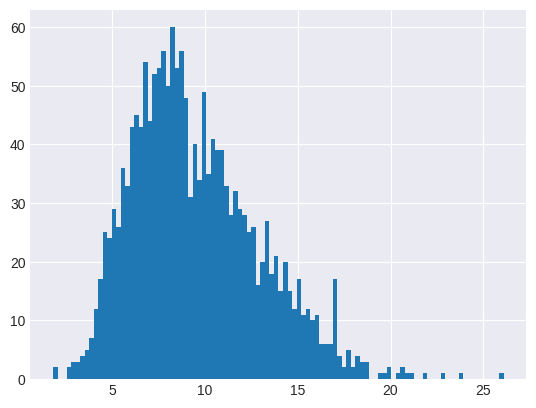

{0: 16084.703649952266}


In [23]:
# Initialize an instance of RFSIM

exprf = cp.asnumpy(saved_exprf)

clus_anal = CLUS_ANAL(exprf=exprf, lx=lx, ly=ly, lz=lz , pixel=pixel, z_pixel=z_pixel)

masked_positions = clus_anal.masking(cutoff = n_sigma+1)
sub_manifolds, total_mass = clus_anal.submanifolds(masked_positions)

for ii in range(masked_positions.shape[0]):
    plt.hist(sub_manifolds[ii].flatten(),bins=100);
    plt.show()

print(total_mass)

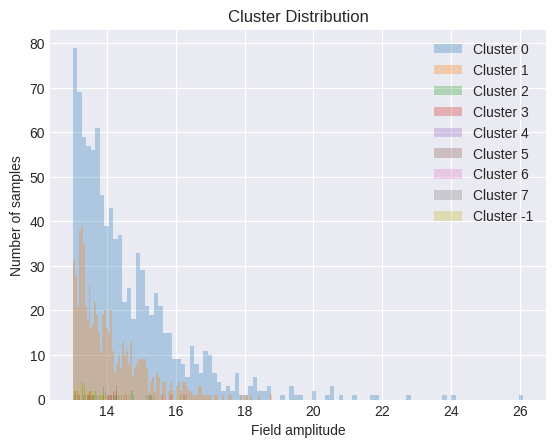

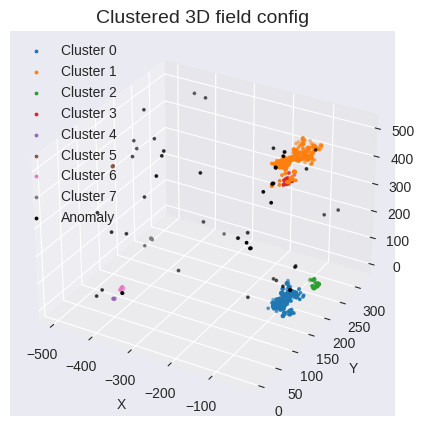

In [29]:
masked_positions = clus_anal.masking(cutoff = 13)
cluster_labels = clus_anal.dbscan(eps=20, min_sam=5, masked_positions=masked_positions)
distances = clus_anal.cluster_distances(masked_positions, cluster_labels)
cluster_field_values = clus_anal.cluster_distribution_3d(masked_positions, cluster_labels)
clus_anal.cluster_plot_3D(masked_positions, cluster_labels)

In [19]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [16]:
saved_exprf = cp.load('simulated_field_75/exprf_75.npy')

<ipython-input-2-0e79851809b3>:92: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


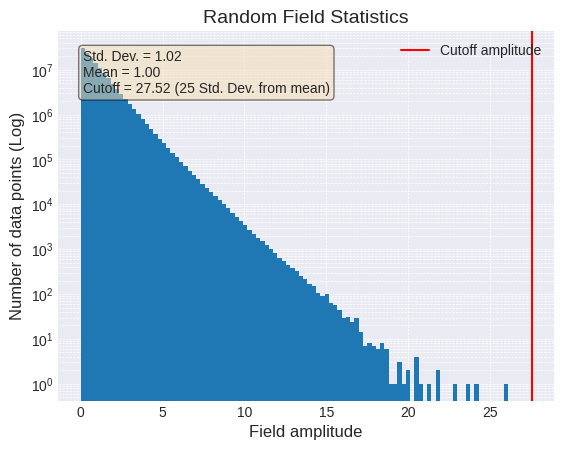

In [17]:
stat_fig, cutoff, exprf_std, exprf_mean = rfsim.statistic_overview(saved_exprf)

In [20]:
filepath = '/gdrive/MyDrive/2023 RFSimulations/simulated_field/'
cp.save(filepath + '', saved_exprf)